# **Прогноз стоимости медицинской страховки**
# Цель задачи
Основная задача - на основе набора данных разработать модель МО, которая будет прогнозировать годовые медицинские расходы (`annual_medical_cost`). Необходимо построить модель, которая принимает на вход персональные данные и информацию о здоровье человека и предсказывает, сколько денег будет потрачено на его медицинское обслуживание в течение года.

В качестве входных данных для модели будут использоваться такие характеристики, как возраст (`age`), пол (`sex`), индекс массы тела (`bmi`), статус курения (`smoker`), регион проживания (`region`), доход (`income`), наличие хронических заболеваний (`chronic_count`) и другие параметры.
Прогнозируемой величиной является годовые медицинские расходы (`annual_medical_cost`).

Так как целевая переменная - непрерывная числовая величина, то это задача регрессии.

# Импорт библиотек

In [1]:
import kagglehub as kh
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import time
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import ks_2samp, ttest_ind, normaltest
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor

# Настройка

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)

# Загрузка данных

In [3]:
path = kh.dataset_download(
    "mohankrishnathalla/medical-insurance-cost-prediction")

print("Path to dataset files:", path)
csv = f"{path}/medical_insurance.csv"

Using Colab cache for faster access to the 'medical-insurance-cost-prediction' dataset.
Path to dataset files: /kaggle/input/medical-insurance-cost-prediction


# Чтение данных

In [4]:
df = pd.read_csv(csv)

print(f"Размер датасета: {df.shape}\n")
print('=' * 50)
print("\nТипы данных:")
print(df.dtypes.value_counts())
print('\n')
print('=' * 50)
print("\nПервые 5 строк данных:")
pd.DataFrame(df.head())

Размер датасета: (100000, 54)


Типы данных:
int64      31
float64    13
object     10
Name: count, dtype: int64



Первые 5 строк данных:


,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


# **Основные характеристики**
# Информация о датафрейме

In [5]:
print("Информация о датафрейме:")
print(df.info())

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       10000

# Пропущенные значения

In [6]:
print("Пропущенные значения:")
print(df.isnull().sum())

Пропущенные значения:
person_id                          0
age                                0
sex                                0
region                             0
urban_rural                        0
income                             0
education                          0
marital_status                     0
employment_status                  0
household_size                     0
dependents                         0
bmi                                0
smoker                             0
alcohol_freq                   30083
visits_last_year                   0
hospitalizations_last_3yrs         0
days_hospitalized_last_3yrs        0
medication_count                   0
systolic_bp                        0
diastolic_bp                       0
ldl                                0
hba1c                              0
plan_type                          0
network_tier                       0
deductible                         0
copay                              0
policy_term_year

# Статистическое описание числовых переменных

In [7]:
print("Статистическое описание числовых переменных:")
pd.DataFrame(df.describe())

Статистическое описание числовых переменных:


,person_id,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
count,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
mean,50000.500000,47.521500,4.987390e+04,2.430900,0.898380,26.990512,1.92765,0.093640,0.373350,1.236320,...,0.014770,0.108310,0.130140,0.508530,0.158690,0.508390,0.50933,0.509140,0.367810,0.169700
std,28867.657797,15.988752,4.680021e+04,1.075126,0.950654,4.994883,1.73773,0.304848,1.373011,1.209358,...,0.120632,0.310773,0.336459,0.749755,0.463562,0.747218,0.75363,0.750455,0.482212,0.375371
min,1.000000,0.000000,1.100000e+03,1.000000,0.000000,12.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25000.750000,37.000000,2.110000e+04,2.000000,0.000000,23.600000,1.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,50000.500000,48.000000,3.620000e+04,2.000000,1.000000,27.000000,2.00000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,75000.250000,58.000000,6.220000e+04,3.000000,1.000000,30.400000,3.00000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000
max,100000.000000,100.000000,1.061800e+06,9.000000,7.000000,50.400000,25.00000,3.000000,21.000000,11.000000,...,1.000000,1.000000,1.000000,7.000000,6.000000,7.000000,7.00000,7.000000,1.000000,1.000000


# Статистика категориальных переменных

In [8]:
categorical_cols = df.select_dtypes(include=["object"]).columns
print(f"Категориальные колонки ({len(categorical_cols)}): {list(categorical_cols)}")

for col in categorical_cols:
  print('=' * 50)
  print(f"{col}:")
  print(f"Уникальных значений: {df[col].nunique()}")
  print("Распределение:")
  print(df[col].value_counts().head())

Категориальные колонки (10): ['sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq', 'plan_type', 'network_tier']
sex:
Уникальных значений: 3
Распределение:
sex
Female    49193
Male      48794
Other      2013
Name: count, dtype: int64
region:
Уникальных значений: 5
Распределение:
region
South      28029
North      22027
East       19984
West       17879
Central    12081
Name: count, dtype: int64
urban_rural:
Уникальных значений: 3
Распределение:
urban_rural
Urban       60019
Suburban    25021
Rural       14960
Name: count, dtype: int64
education:
Уникальных значений: 6
Распределение:
education
Bachelors       27996
Some College    25112
HS              24827
Masters         13987
No HS            5120
Name: count, dtype: int64
marital_status:
Уникальных значений: 4
Распределение:
marital_status
Married     53252
Single      35715
Divorced     6984
Widowed      4049
Name: count, dtype: int64
employment_status:
Уникальных значений: 4

# Анализ целевой переменной

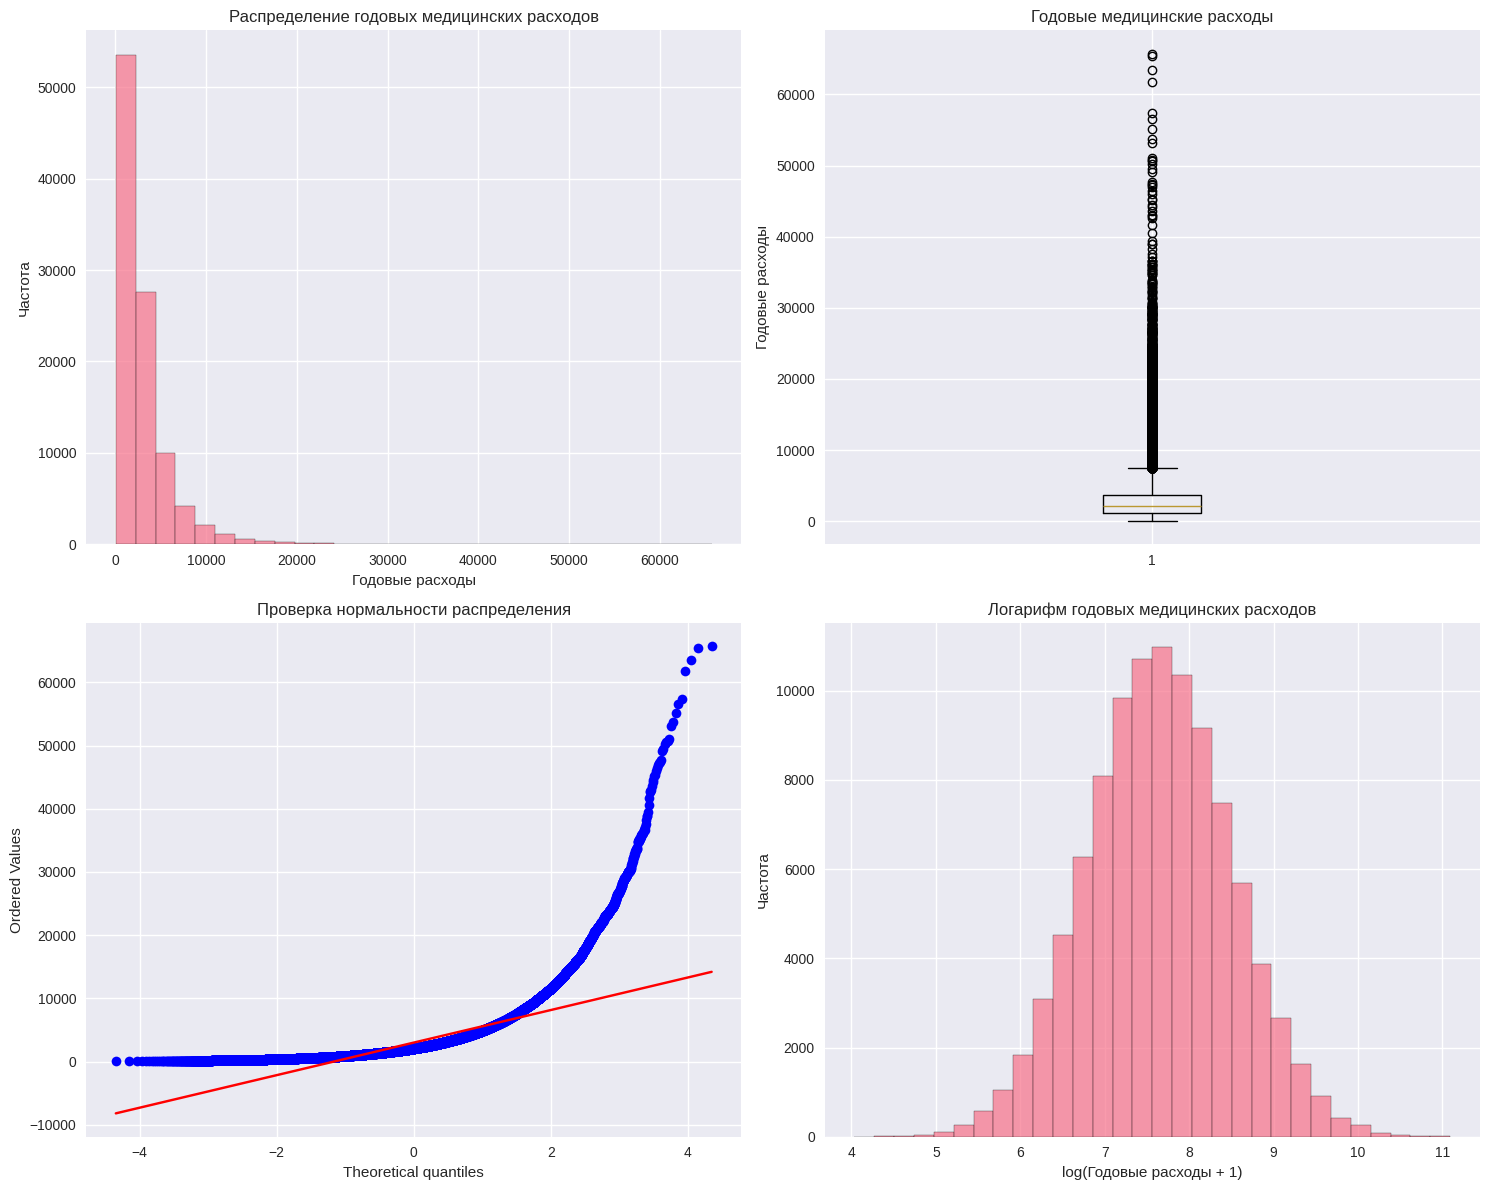

Статистики целевой переменной:
Среднее: 3009.45
Медиана: 2082.57
Стандартное отклонение: 3127.46
Минимум: 55.55
Максимум: 65724.90
Асимметрия: 4.03
Эксцесс: 32.56


In [9]:
fig, axes = plt.subplots(2, 2, figsize = (15, 12))

axes[0, 0].hist(df["annual_medical_cost"], bins = 30,
                edgecolor = "black", alpha = 0.7)
axes[0, 0].set_title("Распределение годовых медицинских расходов")
axes[0, 0].set_xlabel("Годовые расходы")
axes[0, 0].set_ylabel("Частота")

axes[0, 1].boxplot(df["annual_medical_cost"])
axes[0, 1].set_title("Годовые медицинские расходы")
axes[0, 1].set_ylabel("Годовые расходы")

stats.probplot(df["annual_medical_cost"], dist = "norm", plot = axes[1, 0])
axes[1, 0].set_title("Проверка нормальности распределения")

if df["annual_medical_cost"].min() > 0:
  axes[1, 1].hist(np.log1p(df["annual_medical_cost"]), bins = 30,
                  edgecolor = "black", alpha = 0.7)
  axes[1, 1].set_title("Логарифм годовых медицинских расходов")
  axes[1, 1].set_xlabel("log(Годовые расходы + 1)")
  axes[1, 1].set_ylabel("Частота")

plt.tight_layout()
plt.show()

target_stats = {
  "Среднее": df["annual_medical_cost"].mean(),
  "Медиана": df["annual_medical_cost"].median(),
  "Стандартное отклонение": df["annual_medical_cost"].std(),
  "Минимум": df["annual_medical_cost"].min(),
  "Максимум": df["annual_medical_cost"].max(),
  "Асимметрия": df["annual_medical_cost"].skew(),
  "Эксцесс": df["annual_medical_cost"].kurtosis()
}

print('=' * 50)
print("Статистики целевой переменной:")
for stat, value in target_stats.items():
  print(f"{stat}: {value:.2f}")

# Корреляционный анализ

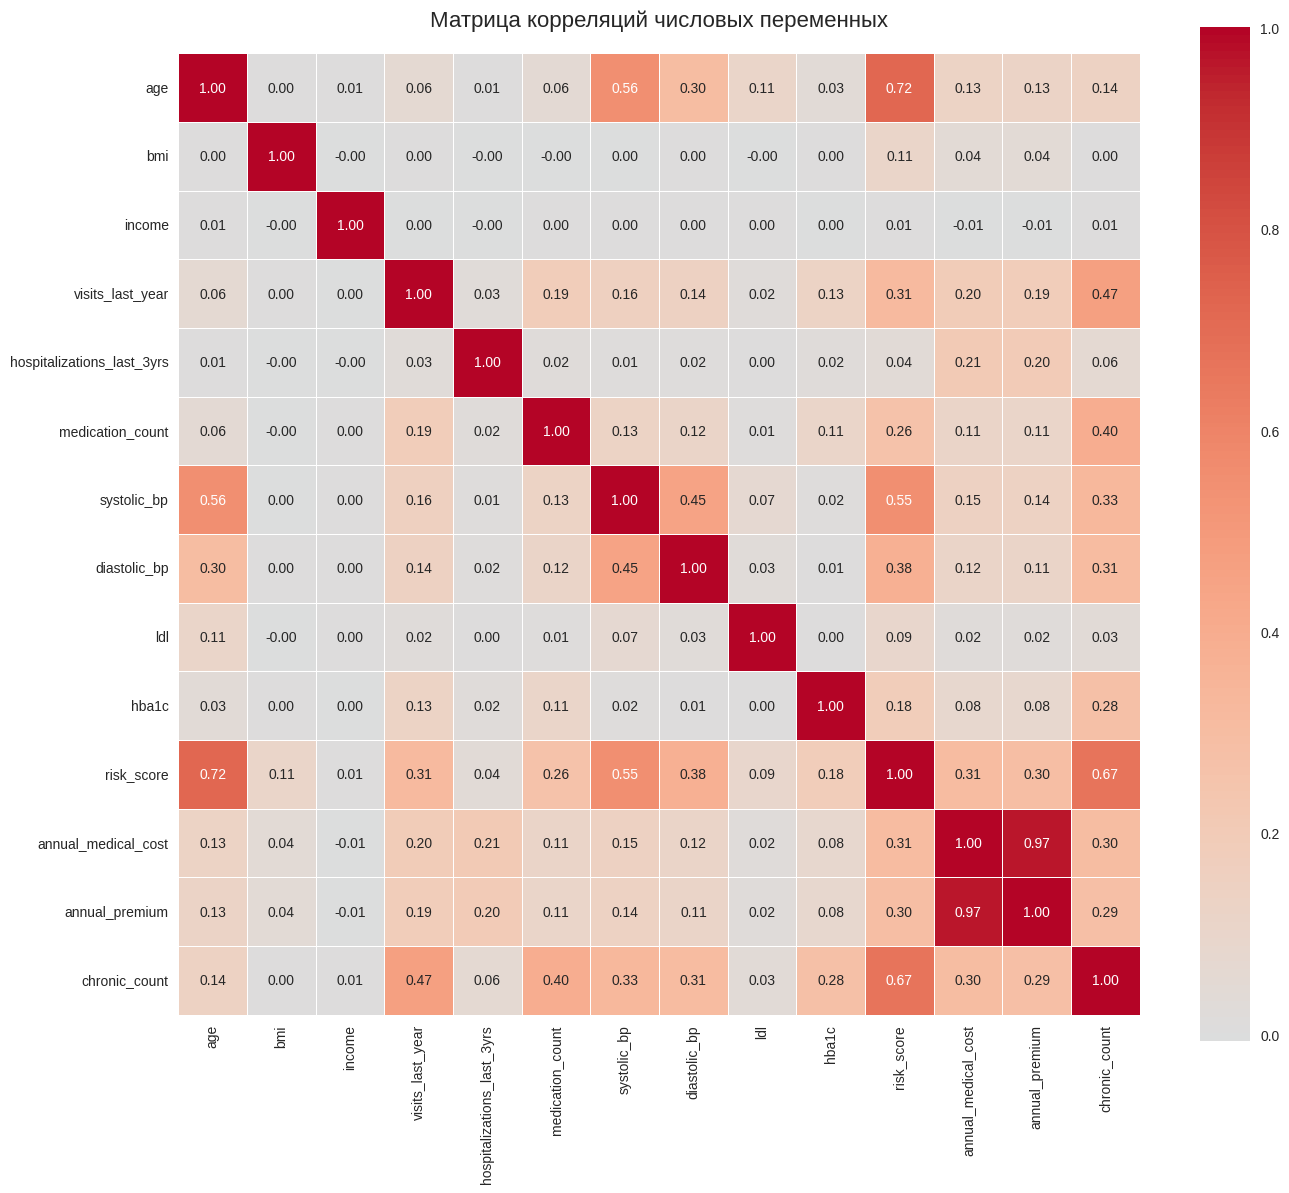

10 переменных по корреляции с annual_medical_cost:


,annual_medical_cost
annual_medical_cost,1.000000
annual_premium,0.965415
risk_score,0.305971
chronic_count,0.296720
hospitalizations_last_3yrs,0.208640
visits_last_year,0.195631
systolic_bp,0.145070
age,0.131166
diastolic_bp,0.117647
medication_count,0.113456


In [10]:
important_numerical = ["age", "bmi", "income", "visits_last_year",
                       "hospitalizations_last_3yrs", "medication_count",
                       "systolic_bp", "diastolic_bp", "ldl", "hba1c",
                       "risk_score", "annual_medical_cost", "annual_premium",
                       "chronic_count"]

existing_cols = [col for col in important_numerical if col in df.columns]
correlation_matrix = df[existing_cols].corr()

plt.figure(figsize = (14, 12))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", center = 0,
            square = True, fmt = ".2f", linewidths = 0.5)
plt.title("Матрица корреляций числовых переменных", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

print('=' * 50)
print("10 переменных по корреляции с annual_medical_cost:")
target_correlations = correlation_matrix["annual_medical_cost"].sort_values(
    ascending = False)
display(target_correlations.head(10))

# Анализ важных переменных

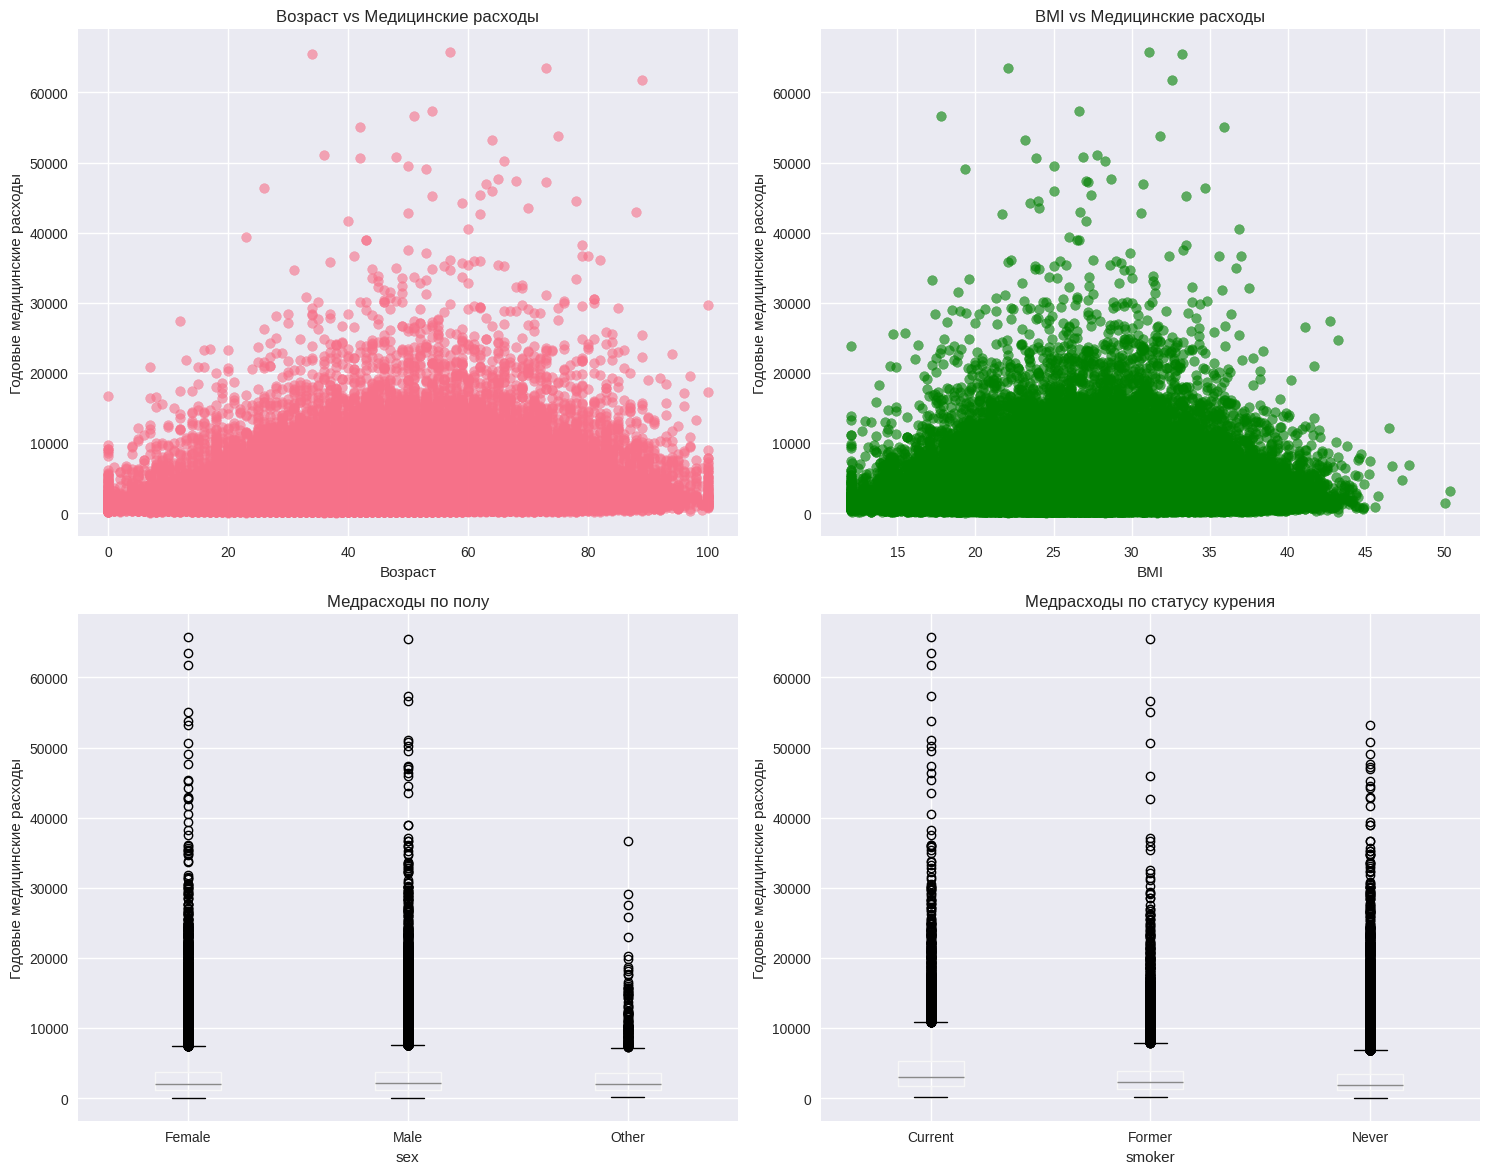

In [11]:
fig, axes = plt.subplots(2, 2, figsize = (15, 12))

axes[0, 0].scatter(df["age"], df["annual_medical_cost"], alpha = 0.6)
axes[0, 0].set_xlabel("Возраст")
axes[0, 0].set_ylabel("Годовые медицинские расходы")
axes[0, 0].set_title("Возраст vs Медицинские расходы")

axes[0, 1].scatter(df["bmi"], df["annual_medical_cost"], alpha = 0.6,
                   color = "green")
axes[0, 1].set_xlabel("BMI")
axes[0, 1].set_ylabel("Годовые медицинские расходы")
axes[0, 1].set_title("BMI vs Медицинские расходы")

if "sex" in df.columns:
  df.boxplot(column = "annual_medical_cost", by = "sex", ax = axes[1, 0])
  axes[1, 0].set_title("Медрасходы по полу")
  axes[1, 0].set_ylabel("Годовые медицинские расходы")

if "smoker" in df.columns:
  df.boxplot(column = "annual_medical_cost", by = "smoker", ax = axes[1, 1])
  axes[1, 1].set_title("Медрасходы по статусу курения")
  axes[1, 1].set_ylabel("Годовые медицинские расходы")

plt.suptitle('')
plt.tight_layout()
plt.show()

# Анализ выбросов

In [12]:
def detect_outliers_iqr(series):
  Q1 = series.quantile(0.25)
  Q3 = series.quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = series[(series < lower_bound) | (series > upper_bound)]
  return len(outliers)

important_vars = ["age", "bmi", "income", "annual_medical_cost"]
outliers_info = {}
for var in important_vars:
  if var in df.columns:
    n_outliers = detect_outliers_iqr(df[var])
    outliers_info[var] = n_outliers

print("Количество выбросов (метод IQR):")
for var, n in outliers_info.items():
  print(f"{var}: {n} выбросов ({n/len(df)*100:.1f}%)")

Количество выбросов (метод IQR):
age: 864 выбросов (0.9%)
bmi: 676 выбросов (0.7%)
income: 6236 выбросов (6.2%)
annual_medical_cost: 6772 выбросов (6.8%)


# Основные выводы

In [13]:
print(f" Размер данных: {df.shape[0]} наблюдений, {df.shape[1]} признаков")
print(f" Целевая переменная: среднее = {df["annual_medical_cost"].mean():.2f}, медиана = {df["annual_medical_cost"].median():.2f}")
print(f" Распределение целевой переменной: асимметрия = {df["annual_medical_cost"].skew():.2f}")
print(f" Пропущенные значения: {"есть" if df.isnull().sum().sum() > 0 else "отсутствуют"}")
print(f" Самые сильные корреляции с целевой:")
for i, (var, corr) in enumerate(target_correlations.items()):
  if i < 5 and var != "annual_medical_cost":
    print(f"  - {var}: {corr:.3f}")

 Размер данных: 100000 наблюдений, 54 признаков
 Целевая переменная: среднее = 3009.45, медиана = 2082.57
 Распределение целевой переменной: асимметрия = 4.03
 Пропущенные значения: есть
 Самые сильные корреляции с целевой:
  - annual_premium: 0.965
  - risk_score: 0.306
  - chronic_count: 0.297
  - hospitalizations_last_3yrs: 0.209


# **Обработка пропущенных значений**

Текущее распределение значений:
alcohol_freq
Occasional    45078
NaN           30083
Weekly        19833
Daily          5006
Name: count, dtype: int64

Всего пропусков (None): 30083
Процент пропусков: 30.08%

Анализ взаимосвязи пропусков в alcohol_freq с другими переменными:


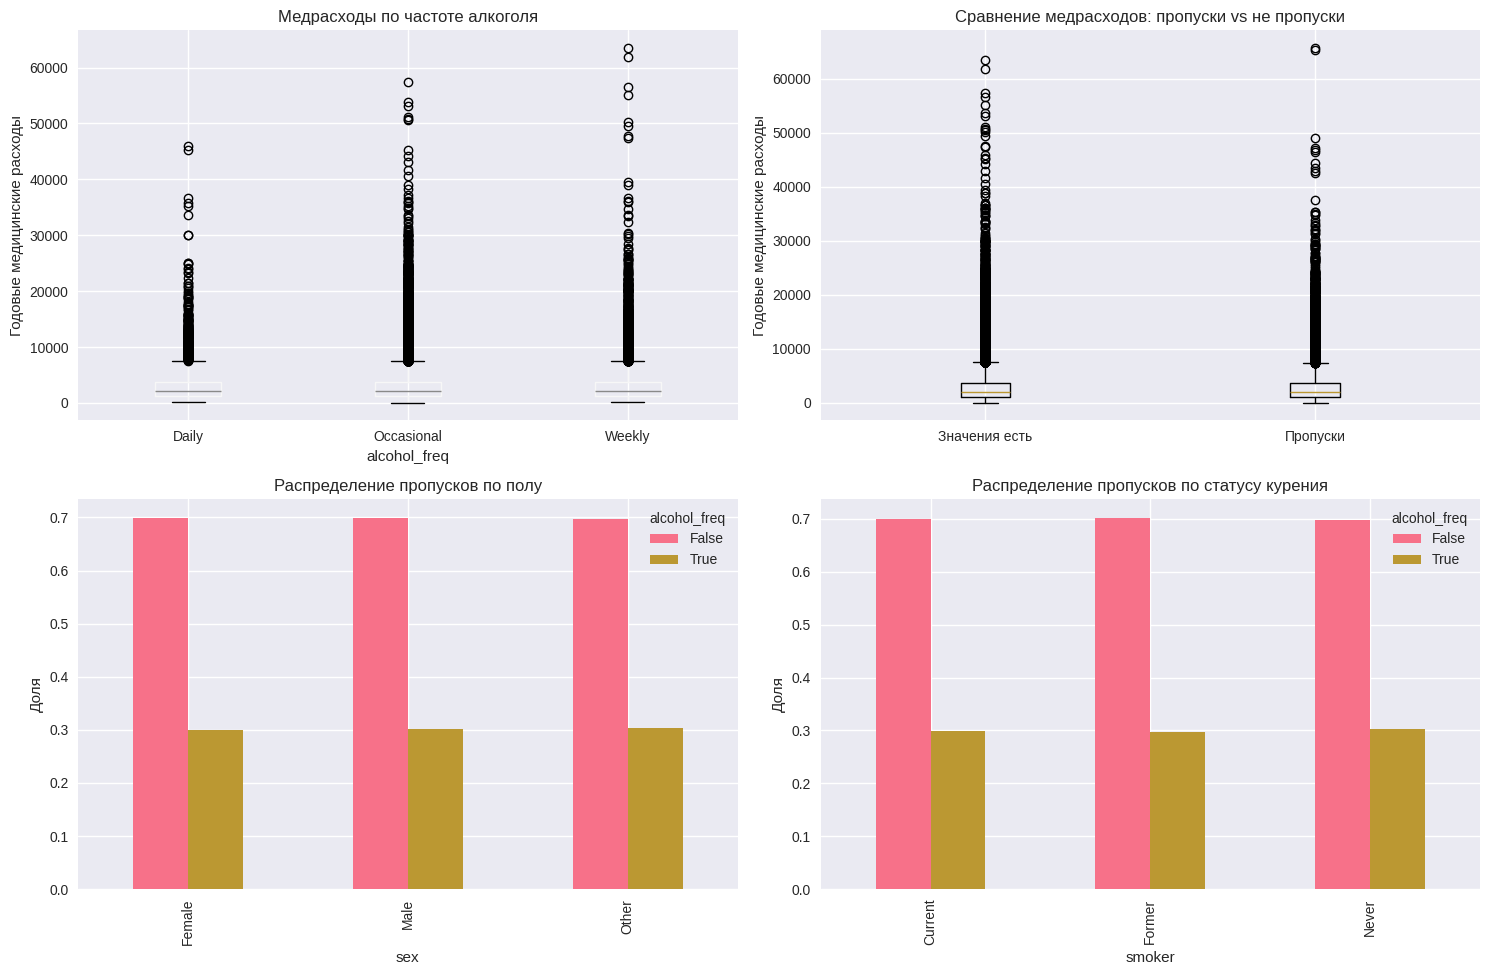


Статистический анализ:
Средние медрасходы при наличии данных: 3006.57
Средние медрасходы при пропусках: 3016.14
T-тест: p-value = 0.6594
Нет статистически значимых различий


In [14]:
print("Текущее распределение значений:")
alcohol_distribution = df["alcohol_freq"].value_counts(dropna = False)
print(alcohol_distribution)

print(f"\nВсего пропусков (None): {df["alcohol_freq"].isnull().sum()}")
print(f"Процент пропусков: {df["alcohol_freq"].isnull().mean() * 100:.2f}%")

print("\nАнализ взаимосвязи пропусков в alcohol_freq с другими переменными:")
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

available_data = df[df["alcohol_freq"].notnull()]
if len(available_data) > 0:
  available_data.boxplot(column = "annual_medical_cost", by = "alcohol_freq",
                         ax = axes[0,0])
  axes[0,0].set_title("Медрасходы по частоте алкоголя")
  axes[0,0].set_ylabel("Годовые медицинские расходы")

missing_mask = df["alcohol_freq"].isnull()
box_plot_data = [df[~missing_mask]["annual_medical_cost"],
                 df[missing_mask]["annual_medical_cost"]]
boxes = axes[0,1].boxplot(box_plot_data)
axes[0,1].set_xticklabels(["Значения есть", "Пропуски"])
axes[0,1].set_title("Сравнение медрасходов: пропуски vs не пропуски")
axes[0,1].set_ylabel("Годовые медицинские расходы")

if "sex" in df.columns:
  pd.crosstab(df["sex"], df["alcohol_freq"].isnull(),
              normalize = "index").plot(kind = "bar", ax = axes[1,0])
  axes[1,0].set_title("Распределение пропусков по полу")
  axes[1,0].set_ylabel("Доля")

if "smoker" in df.columns:
  pd.crosstab(df["smoker"], df["alcohol_freq"].isnull(),
              normalize = "index").plot(kind = "bar", ax = axes[1,1])
  axes[1,1].set_title("Распределение пропусков по статусу курения")
  axes[1,1].set_ylabel("Доля")

plt.suptitle('')
plt.tight_layout()
plt.show()

print("\nСтатистический анализ:")
if missing_mask.sum() > 0:
  group_with_data = df[~missing_mask]["annual_medical_cost"]
  group_missing = df[missing_mask]["annual_medical_cost"]

  print(f"Средние медрасходы при наличии данных: {group_with_data.mean():.2f}")
  print(f"Средние медрасходы при пропусках: {group_missing.mean():.2f}")

  t_stat, p_value = stats.ttest_ind(group_with_data.dropna(),
                                    group_missing.dropna(), equal_var = False)
  print(f"T-тест: p-value = {p_value:.4f}")
  if p_value < 0.05:
    print("Статистически значимые различия (p < 0.05)")
  else:
    print("Нет статистически значимых различий")

df_processed = df.copy()
df_processed["alcohol_freq"] = df["alcohol_freq"].fillna("Never")

# **Обработка категориальных признаков**
# Идентификация категориальных признаков

In [15]:
categorical_cols = df_processed.select_dtypes(include = ["object"]).columns
print(f"Найдено категориальных колонок: {len(categorical_cols)}")
print(f"Список: {list(categorical_cols)}")

print("\nАнализ уникальных значений:")
category_analysis = []
for col in categorical_cols:
  unique_count = df_processed[col].nunique()
  unique_values = df_processed[col].unique()[:5]
  category_analysis.append({
    "Колонка": col,
    "Уникальных значений": unique_count,
    "Примеры значений": list(unique_values)
  })

category_df = pd.DataFrame(category_analysis)
display(category_df)

Найдено категориальных колонок: 10
Список: ['sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq', 'plan_type', 'network_tier']

Анализ уникальных значений:


,Колонка,Уникальных значений,Примеры значений
0,sex,3,"[Female, Male, Other]"
1,region,5,"[North, Central, West, South, East]"
2,urban_rural,3,"[Suburban, Urban, Rural]"
3,education,6,"[Doctorate, No HS, HS, Some College, Masters]"
4,marital_status,4,"[Married, Single, Divorced, Widowed]"
5,employment_status,4,"[Retired, Employed, Self-employed, Unemployed]"
6,smoker,3,"[Never, Current, Former]"
7,alcohol_freq,4,"[Never, Weekly, Daily, Occasional]"
8,plan_type,4,"[PPO, POS, HMO, EPO]"
9,network_tier,4,"[Bronze, Gold, Platinum, Silver]"


# Стратегия обработки для каждого типа категориальных переменных

In [16]:
binary_cols = []
low_cardinality_cols = []
high_cardinality_cols = []

for col in categorical_cols:
  unique_count = df_processed[col].nunique()

  if unique_count == 2:
    binary_cols.append(col)
    print(f"{col}: Бинарная ({unique_count} значения)")
  elif 3 <= unique_count <= 10:
    low_cardinality_cols.append(col)
    print(f"{col}: Низкая кардинальность ({unique_count} значений)")
  else:
    high_cardinality_cols.append(col)
    print(f"{col}: Высокая кардинальность ({unique_count} значений)")

sex: Низкая кардинальность (3 значений)
region: Низкая кардинальность (5 значений)
urban_rural: Низкая кардинальность (3 значений)
education: Низкая кардинальность (6 значений)
marital_status: Низкая кардинальность (4 значений)
employment_status: Низкая кардинальность (4 значений)
smoker: Низкая кардинальность (3 значений)
alcohol_freq: Низкая кардинальность (4 значений)
plan_type: Низкая кардинальность (4 значений)
network_tier: Низкая кардинальность (4 значений)


# Обработка

In [17]:
label_encoders = {}
df_encoded = df_processed.copy()

for col in binary_cols:
  print(f"До кодирования: {df_encoded[col].unique()}")

  le = LabelEncoder()
  df_encoded[col] = le.fit_transform(df_encoded[col])
  label_encoders[col] = le

  print(f"После кодирования: {df_encoded[col].unique()}")
  print(f"Соответствие: {dict(zip(le.classes_, le.transform(le.classes_)))}")
  print('-' * 30)

if low_cardinality_cols:
  print(f"Колонки для One-Hot Encoding: {low_cardinality_cols}")
  df_encoded = pd.get_dummies(df_encoded, columns = low_cardinality_cols,
                              prefix = low_cardinality_cols)

  print(f"После One-Hot Encoding размер датасета: {df_encoded.shape}")
  new_ohe_columns = [col for col in df_encoded.columns if
                     any(col.startswith(prefix) for
                         prefix in low_cardinality_cols)]
  print(f"Создано новых бинарных колонок: {len(new_ohe_columns)}")
  print(f"Примеры новых колонок: {new_ohe_columns[:10]}...")

if high_cardinality_cols:
  print(f"Колонки с высокой кардинальностью: {high_cardinality_cols}")
  for col in high_cardinality_cols:
    freq_encoding = df_encoded[col].value_counts(normalize = True)
    print(f"5 самых частых значений:")
    print(freq_encoding.head())
    freq_map = freq_encoding.to_dict()
    df_encoded[f"{col}_freq_encoded"] = df_encoded[col].map(freq_map)
    print(f"Создана новая колонка: {col}_freq_encoded")
  df_encoded = df_encoded.drop(columns = high_cardinality_cols)
  print(f"\nУдалены оригинальные колонки с высокой кардинальностью")

remaining_categorical = df_encoded.select_dtypes(include = ["object"]).columns
if len(remaining_categorical) > 0:
  print(f"Остались необработанные категориальные колонки: {list(remaining_categorical)}")
else:
  print("Все категориальные колонки обработаны!")

print(f"\nРазмер датасета до обработки: {df_processed.shape}")
print(f"Размер датасета после обработки: {df_encoded.shape}")
print(f"Добавлено колонок: {df_encoded.shape[1] - df_processed.shape[1]}")

df_final = df_encoded.copy()

print(f"\nТипы данных в финальном датасете:")
print(df_final.dtypes.value_counts())

Колонки для One-Hot Encoding: ['sex', 'region', 'urban_rural', 'education', 'marital_status', 'employment_status', 'smoker', 'alcohol_freq', 'plan_type', 'network_tier']
После One-Hot Encoding размер датасета: (100000, 84)
Создано новых бинарных колонок: 40
Примеры новых колонок: ['sex_Female', 'sex_Male', 'sex_Other', 'region_Central', 'region_East', 'region_North', 'region_South', 'region_West', 'urban_rural_Rural', 'urban_rural_Suburban']...
Все категориальные колонки обработаны!

Размер датасета до обработки: (100000, 54)
Размер датасета после обработки: (100000, 84)
Добавлено колонок: 30

Типы данных в финальном датасете:
bool       40
int64      31
float64    13
Name: count, dtype: int64


# Визуализация

Визуализируем преобразование для колонки: sex


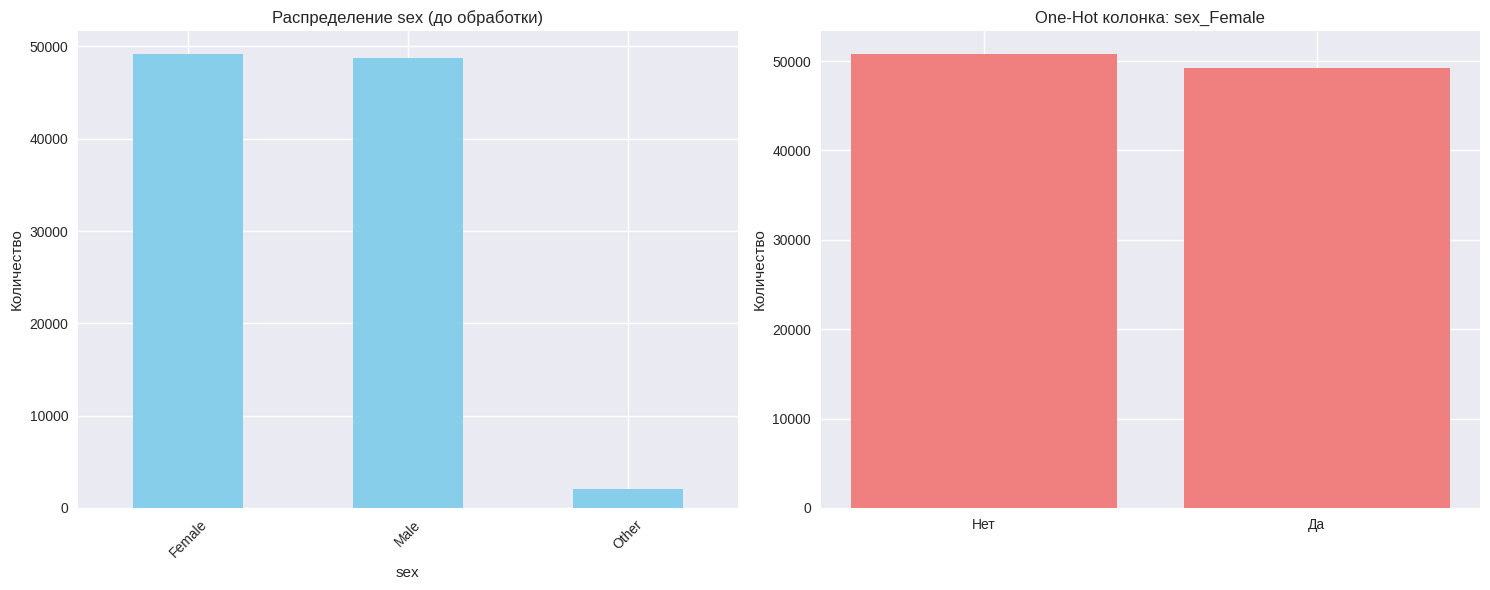


Информация о преобразовании 'sex':
- Метод: One-Hot Encoding
- Создано колонок: 3
- Примеры: ['sex_Female', 'sex_Male', 'sex_Other']


In [18]:
if len(categorical_cols) > 0:
  example_col = categorical_cols[0]
  print(f"Визуализируем преобразование для колонки: {example_col}")

  fig, axes = plt.subplots(1, 2, figsize=(15, 6))

  if example_col in df_processed.columns:
    df_processed[example_col].value_counts().head(10).plot(kind = "bar",
                                                           ax = axes[0],
                                                           color = "skyblue")
    axes[0].set_title(f"Распределение {example_col} (до обработки)")
    axes[0].tick_params(axis = "x", rotation = 45)
    axes[0].set_ylabel("Количество")
  else:
    axes[0].text(0.5, 0.5, f"Колонка {example_col} не найдена",
                 ha = "center", va = "center", transform = axes[0].transAxes)
    axes[0].set_title(f"До обработки: {example_col}")

  found_after_plot = False

  if example_col in binary_cols and example_col in df_final.columns:
    value_counts = df_final[example_col].value_counts()
    if example_col in label_encoders:
      le = label_encoders[example_col]
      labels = [f"{le.inverse_transform([val])[0]}\n({val})" for
                val in value_counts.index]
    else:
      labels = value_counts.index
      axes[1].bar(range(len(value_counts)), value_counts.values,
                  color = "lightgreen")
      axes[1].set_xticks(range(len(value_counts)))
      axes[1].set_xticklabels(labels)
      axes[1].set_title(f"После Label Encoding: {example_col}")
      axes[1].set_ylabel("Количество")
      found_after_plot = True

  elif any(col.startswith(example_col + '_') for col in df_final.columns):
    ohe_columns = [col for col in df_final.columns if
                   col.startswith(example_col + '_')]
    if ohe_columns:
      sample_ohe_col = ohe_columns[0]
      value_counts = df_final[sample_ohe_col].value_counts()
      axes[1].bar(value_counts.index, value_counts.values, color = "lightcoral")
      axes[1].set_xticks([0, 1])
      axes[1].set_xticklabels(["Нет", "Да"])
      axes[1].set_title(f"One-Hot колонка: {sample_ohe_col}")
      axes[1].set_ylabel("Количество")
      found_after_plot = True

  elif f"{example_col}_freq_encoded" in df_final.columns:
    df_final[f"{example_col}_freq_encoded"].hist(bins = 30, ax = axes[1],
                                                 color = "orange", alpha = 0.7)
    axes[1].set_title(f"После Frequency Encoding: {example_col}")
    axes[1].set_xlabel("Частота встречаемости")
    axes[1].set_ylabel("Количество")
    found_after_plot = True

  elif example_col in df_final.columns:
    df_final[example_col].value_counts().head(10).plot(kind = "bar",
                                                       ax = axes[1],
                                                       color = "yellow")
    axes[1].set_title(f"Без изменений: {example_col}")
    axes[1].tick_params(axis = "x", rotation = 45)
    axes[1].set_ylabel("Количество")
    found_after_plot = True

  if not found_after_plot:
    axes[1].text(0.5, 0.5, "Не удалось визуализировать\nрезультаты обработки",
                 ha = "center", va = "center", transform = axes[1].transAxes,
                 fontsize = 12)
    axes[1].set_title(f"После обработки: {example_col}")

  plt.tight_layout()
  plt.show()

  print(f"\nИнформация о преобразовании '{example_col}':")
  if example_col in binary_cols:
    print(f"- Метод: Label Encoding")
    if example_col in label_encoders:
      le = label_encoders[example_col]
      print(f"- Соответствие: {dict(zip(le.classes_, le.transform(le.classes_)))}")
  elif example_col in low_cardinality_cols:
    print(f"- Метод: One-Hot Encoding")
    ohe_columns = [col for col in df_final.columns if col.startswith(example_col + '_')]
    print(f"- Создано колонок: {len(ohe_columns)}")
    print(f"- Примеры: {ohe_columns[:3]}")
  elif example_col in high_cardinality_cols:
    print(f"- Метод: Frequency Encoding")
    print(f"- Новая колонка: {example_col}_freq_encoded")
  else:
    print(f"- Метод: Неизвестен/колонка не обработана")

else:
  print("Нет категориальных колонок для визуализации.")

In [19]:
encoding_summary = []
for col in categorical_cols:
  if col in binary_cols:
    method = "Label Encoding"
    status = "В датасете" if col in df_final.columns else "Удалена"
  elif col in low_cardinality_cols:
    method = "One-Hot Encoding"
    ohe_cols = [c for c in df_final.columns if c.startswith(col + '_')]
    status = f"Создано {len(ohe_cols)} колонок"
  elif col in high_cardinality_cols:
    method = "Frequency Encoding"
    status = "В датасете" if f"{col}_freq_encoded" in df_final.columns else "Удалена"
  else:
    method = "Не обработана"
    status = "В датасете" if col in df_final.columns else "Удалена"

  encoding_summary.append({
    "Колонка": col,
    "Метод": method,
    "Статус": status
  })

summary_df = pd.DataFrame(encoding_summary)
display(summary_df)

,Колонка,Метод,Статус
0,sex,One-Hot Encoding,Создано 3 колонок
1,region,One-Hot Encoding,Создано 5 колонок
2,urban_rural,One-Hot Encoding,Создано 3 колонок
3,education,One-Hot Encoding,Создано 6 колонок
4,marital_status,One-Hot Encoding,Создано 4 колонок
5,employment_status,One-Hot Encoding,Создано 4 колонок
6,smoker,One-Hot Encoding,Создано 3 колонок
7,alcohol_freq,One-Hot Encoding,Создано 4 колонок
8,plan_type,One-Hot Encoding,Создано 4 колонок
9,network_tier,One-Hot Encoding,Создано 4 колонок


# **Нормализация**
# Анализ масштабов

Количество числовых признаков (без целевой): 43


,Признак,Минимум,Максимум,Диапазон,Среднее,Стд. отклонение
2,income,1100.00,1061800.00,1060700.00,49873.905000,46800.214127
0,person_id,1.00,100000.00,99999.00,50000.500000,28867.657797
24,total_claims_paid,0.00,72517.95,72517.95,1377.878827,2305.464687
23,avg_claim_amount,0.00,30010.53,30010.53,656.512084,1072.660048
20,annual_premium,211.67,10962.55,10750.88,582.320040,399.583722
14,deductible,500.00,5000.00,4500.00,1226.725000,1019.619375
21,monthly_premium,17.64,913.55,895.91,48.526668,33.298640
12,ldl,30.00,248.30,218.30,119.975065,30.262086
10,systolic_bp,61.00,183.00,122.00,117.808970,15.369187
1,age,0.00,100.00,100.00,47.521500,15.988752


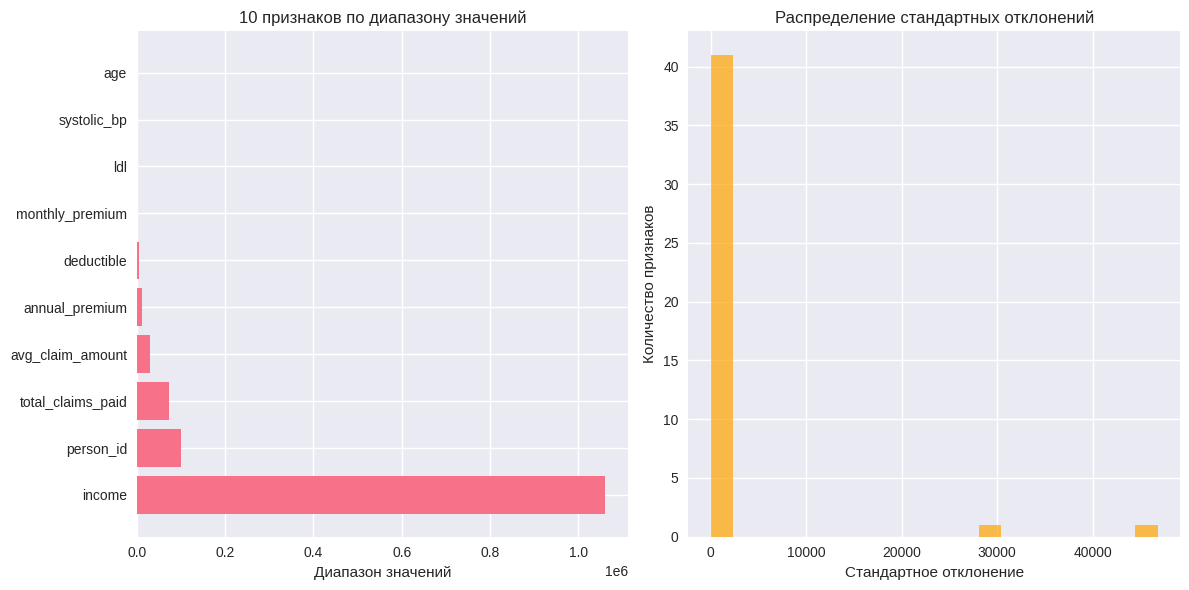

In [20]:
numeric_cols = df_final.select_dtypes(include = [np.number]).columns
numeric_cols = [col for col in numeric_cols if col != "annual_medical_cost"]

print(f"Количество числовых признаков (без целевой): {len(numeric_cols)}")

range_analysis = []
for col in numeric_cols:
  min_val = df_final[col].min()
  max_val = df_final[col].max()
  mean_val = df_final[col].mean()
  std_val = df_final[col].std()
  range_analysis.append({
    "Признак": col,
    "Минимум": min_val,
    "Максимум": max_val,
    "Диапазон": max_val - min_val,
    "Среднее": mean_val,
    "Стд. отклонение": std_val
  })

range_df = pd.DataFrame(range_analysis)
display(range_df.sort_values("Диапазон", ascending = False).head(10))

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
top_ranges = range_df.nlargest(10, "Диапазон")
plt.barh(top_ranges["Признак"], top_ranges["Диапазон"])
plt.xlabel("Диапазон значений")
plt.title("10 признаков по диапазону значений")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.hist(range_df["Стд. отклонение"], bins = 20, alpha = 0.7, color = "orange")
plt.xlabel("Стандартное отклонение")
plt.ylabel("Количество признаков")
plt.title("Распределение стандартных отклонений")
plt.tight_layout()
plt.show()

# Анализ типов

In [21]:
feature_types = {
  "Бинарные (0/1)": [],
  "Проценты/доли (0-1)": [],
  "Небольшой диапазон (<100)": [],
  "Средний диапазон (100-10,000)": [],
  "Большой диапазон (>10,000)": []
}

for col in numeric_cols:
  value_range = df_final[col].max() - df_final[col].min()
  unique_vals = df_final[col].nunique()

  if unique_vals == 2 and set(df_final[col].unique()).issubset({0, 1}):
    feature_types["Бинарные (0/1)"].append(col)
  elif 0 <= df_final[col].min() <= 1 and 0 <= df_final[col].max() <= 1:
    feature_types["Проценты/доли (0-1)"].append(col)
  elif value_range < 100:
    feature_types["Небольшой диапазон (<100)"].append(col)
  elif 100 <= value_range <= 10000:
    feature_types["Средний диапазон (100-10,000)"].append(col)
  else:
    feature_types["Большой диапазон (>10,000)"].append(col)

for feature_type, columns in feature_types.items():
  print(f"{feature_type}: {len(columns)} признаков")
  if columns:
    print(f"  Примеры: {columns[:3]}")
  print()

Бинарные (0/1): 12 признаков
  Примеры: ['hypertension', 'diabetes', 'asthma']

Проценты/доли (0-1): 1 признаков
  Примеры: ['risk_score']

Небольшой диапазон (<100): 20 признаков
  Примеры: ['household_size', 'dependents', 'bmi']

Средний диапазон (100-10,000): 5 признаков
  Примеры: ['age', 'systolic_bp', 'ldl']

Большой диапазон (>10,000): 5 признаков
  Примеры: ['person_id', 'income', 'annual_premium']



# Анализ корреляций

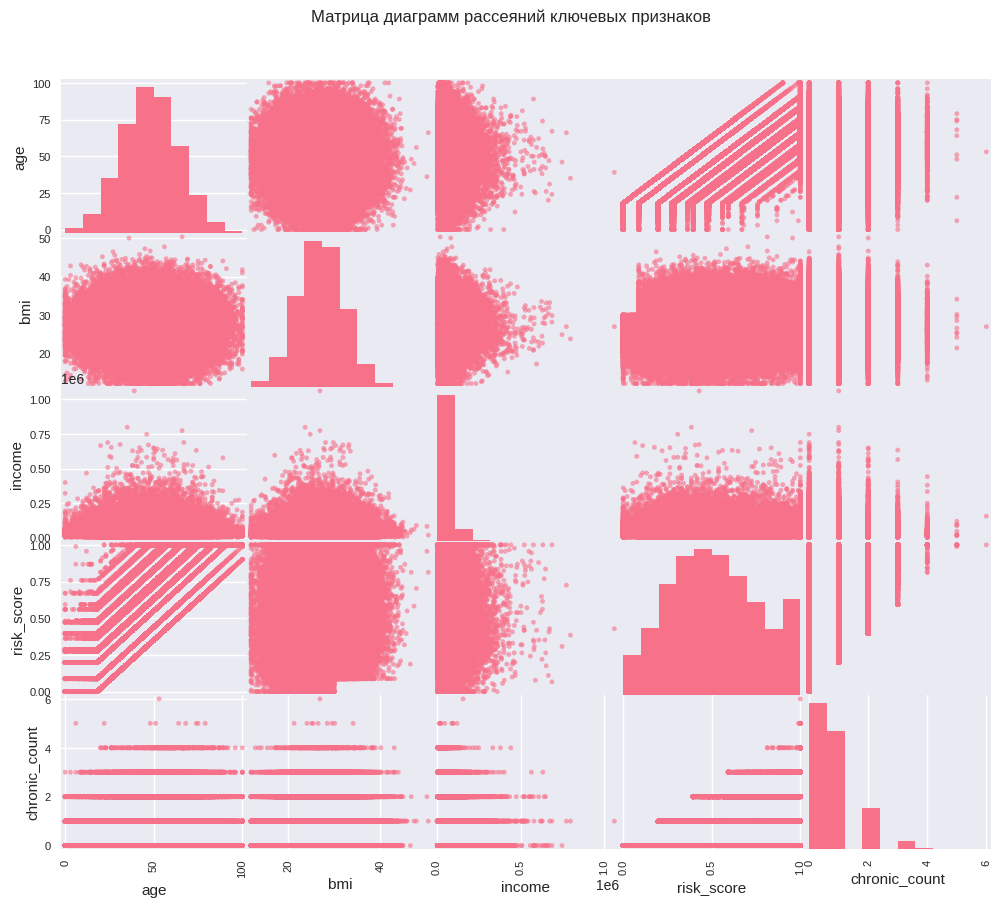

In [22]:
key_features = ["age", "bmi", "income", "risk_score", "chronic_count"]
key_features = [f for f in key_features if f in df_final.columns]

if key_features:
  scatter_matrix = pd.plotting.scatter_matrix(df_final[key_features],
                                              figsize = (12, 10),
                                              alpha = 0.6,
                                              diagonal = "hist")
  plt.suptitle("Матрица диаграмм рассеяний ключевых признаков", y = 0.95)
  plt.show()

# Нормализация

Стратегия нормализация:
- Бинарные признаки: 12
- Признаки в диапазоне 0-1: 1
- Признаки для нормализации: 70

Результаты нормализации:
Размерность данных: (100000, 83)


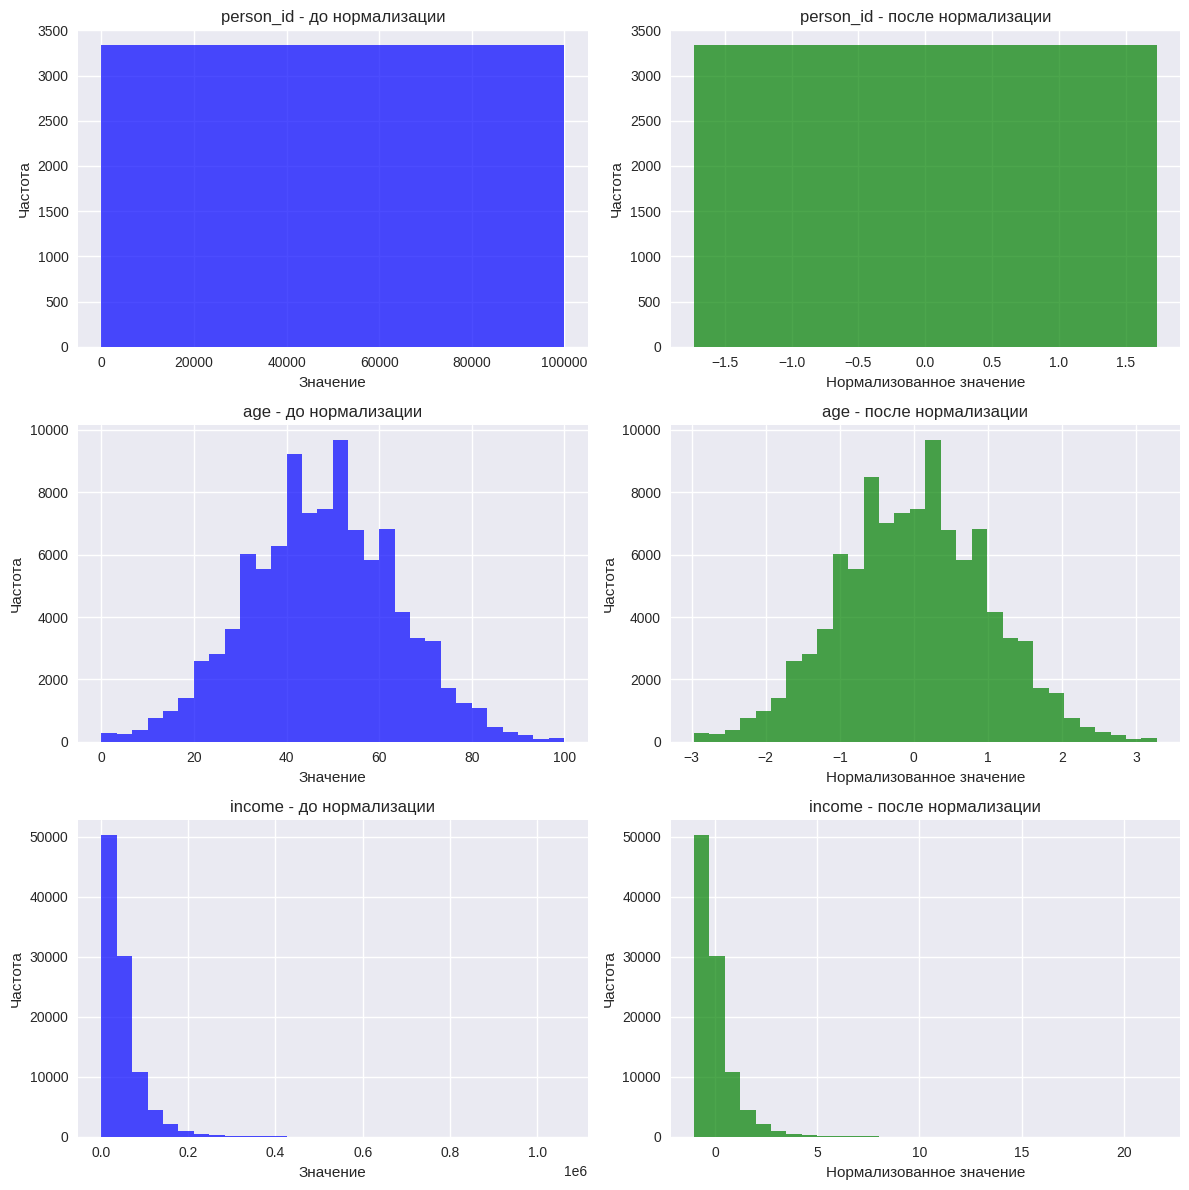


Сравнение статистик до и после нормализации:

person_id:
  До: среднее = 50000.50, стд. отклонение = 28867.66
  После: среднее = -0.00, стд. отклонение = 1.00

age:
  До: среднее = 47.52, стд. отклонение = 15.99
  После: среднее = -0.00, стд. отклонение = 1.00

income:
  До: среднее = 49873.90, стд. отклонение = 46800.21
  После: среднее = 0.00, стд. отклонение = 1.00


In [23]:
df_normalized = df_final.copy()

X = df_normalized.drop("annual_medical_cost", axis = 1)
y = df_normalized["annual_medical_cost"]

print("Стратегия нормализация:")
do_not_scale = []

do_not_scale.extend(feature_types["Бинарные (0/1)"])
print(f"- Бинарные признаки: {len(feature_types["Бинарные (0/1)"])}")

do_not_scale.extend(feature_types["Проценты/доли (0-1)"])
print(f"- Признаки в диапазоне 0-1: {len(feature_types["Проценты/доли (0-1)"])}")

to_scale = [col for col in X.columns if col not in do_not_scale]
print(f"- Признаки для нормализации: {len(to_scale)}")

scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[to_scale] = scaler.fit_transform(X[to_scale])

print("\nРезультаты нормализации:")
print(f"Размерность данных: {X_scaled.shape}")

if to_scale:
  example_features = to_scale[:3] if len(to_scale) >= 3 else to_scale

  fig, axes = plt.subplots(len(example_features), 2,
                           figsize = (12, 4 * len(example_features)))

  for i, feature in enumerate(example_features):
    axes[i, 0].hist(X[feature], bins = 30, alpha = 0.7, color = "blue")
    axes[i, 0].set_title(f"{feature} - до нормализации")
    axes[i, 0].set_xlabel("Значение")
    axes[i, 0].set_ylabel("Частота")

    axes[i, 1].hist(X_scaled[feature], bins = 30, alpha = 0.7, color = "green")
    axes[i, 1].set_title(f"{feature} - после нормализации")
    axes[i, 1].set_xlabel("Нормализованное значение")
    axes[i, 1].set_ylabel("Частота")
  plt.tight_layout()
  plt.show()

  print("\nСравнение статистик до и после нормализации:")
  for feature in example_features:
    print(f"\n{feature}:")
    print(f"  До: среднее = {X[feature].mean():.2f}, стд. отклонение = {X[feature].std():.2f}")
    print(f"  После: среднее = {X_scaled[feature].mean():.2f}, стд. отклонение = {X_scaled[feature].std():.2f}")

df_final_normalized = pd.concat([X_scaled, y], axis = 1)

# **Разбиение данных на обучающую и тестовую выборки**
# Подготовка данных

In [24]:
if "df_final_normalized" in locals():
  X = df_final_normalized.drop("annual_medical_cost", axis = 1)
  y = df_final_normalized["annual_medical_cost"]
  print("Используются нормализованные данные")
else:
  X = df_final.drop("annual_medical_cost", axis = 1)
  y = df_final["annual_medical_cost"]
  print("Используются обработанные данные (без нормализации)")

print(f"Размерность признаков (X): {X.shape}")
print(f"Размерность целевой переменной (y): {y.shape}")

print(f"\nБаланс целевой переменной:")
print(f"Минимум: {y.min():.2f}")
print(f"Максимум: {y.max():.2f}")
print(f"Среднее: {y.mean():.2f}")
print(f"Медиана: {y.median():.2f}")

Используются нормализованные данные
Размерность признаков (X): (100000, 83)
Размерность целевой переменной (y): (100000,)

Баланс целевой переменной:
Минимум: 55.55
Максимум: 65724.90
Среднее: 3009.45
Медиана: 2082.57


# Разделение данных

In [25]:
TEST_SIZE = 0.2
RANDOM_STATE = 42
STRATIFY = None

y_bins = pd.qcut(y, q = 5, labels = False, duplicates = "drop")

print(f"Параметры разделения:")
print(f"- Тестовая выборка: {TEST_SIZE * 100}%")
print(f"- Обучающая выборка: {(1 - TEST_SIZE) * 100}%")
print(f"- Random state: {RANDOM_STATE}")

X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE, stratify = y_bins)

print(f"\nРезультаты разделения:")
print(f"Обучающая выборка: {X_train.shape[0]} samples ({X_train.shape[0]/len(X) * 100:.1f}%)")
print(f"Тестовая выборка: {X_test.shape[0]} samples ({X_test.shape[0]/len(X) * 100:.1f}%)")
print(f"Признаков: {X_train.shape[1]}")

Параметры разделения:
- Тестовая выборка: 20.0%
- Обучающая выборка: 80.0%
- Random state: 42

Результаты разделения:
Обучающая выборка: 80000 samples (80.0%)
Тестовая выборка: 20000 samples (20.0%)
Признаков: 83


# Анализ распределения целевой переменной

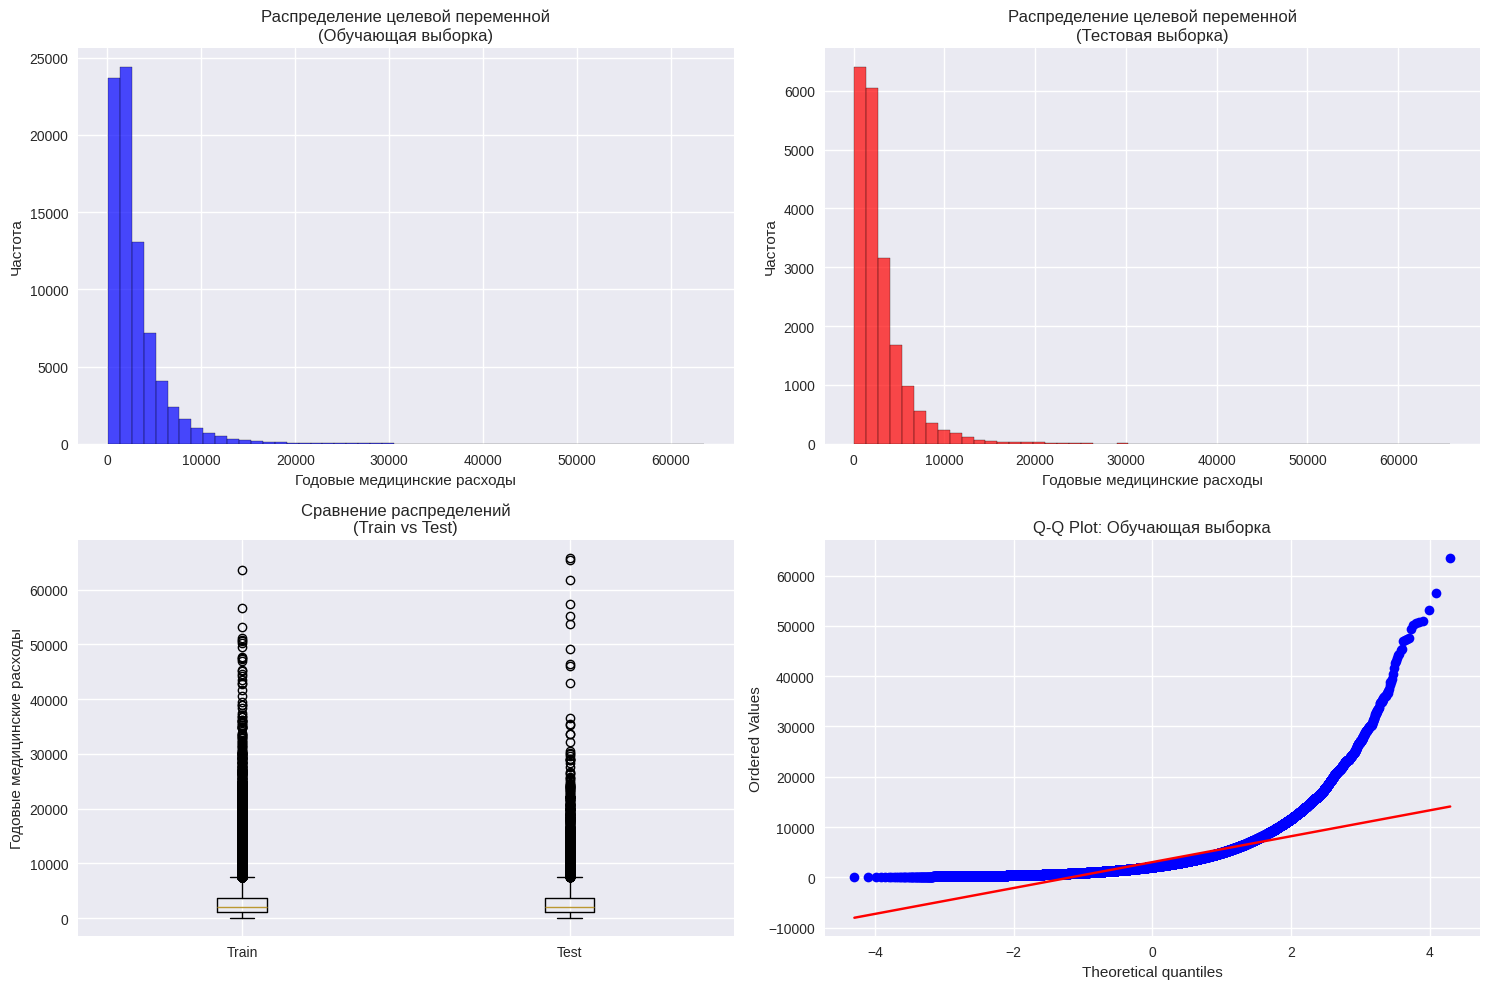

Статистическое сравнение распределений:
Тест Колмогорова-Смирнова: p-value = 0.9498
T-тест: p-value = 0.7380
Распределения статистически не различаются (p > 0.05)

Сравнение статистик:


,Обучающая выборка,Тестовая выборка,Разница (%)
count,80000.00,20000.00,75.00
mean,3011.13,3002.75,0.28
std,3114.07,3180.53,-2.13
min,55.55,85.76,-54.38
25%,1175.52,1174.11,0.12
50%,2084.54,2073.31,0.54
75%,3705.10,3715.78,-0.29
max,63482.48,65724.90,-3.53


In [26]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

axes[0, 0].hist(y_train, bins = 50, alpha = 0.7,
                color = "blue", edgecolor = "black")
axes[0, 0].set_title("Распределение целевой переменной\n(Обучающая выборка)")
axes[0, 0].set_xlabel("Годовые медицинские расходы")
axes[0, 0].set_ylabel("Частота")

axes[0, 1].hist(y_test, bins = 50, alpha = 0.7,
                color = "red", edgecolor = "black")
axes[0, 1].set_title("Распределение целевой переменной\n(Тестовая выборка)")
axes[0, 1].set_xlabel("Годовые медицинские расходы")
axes[0, 1].set_ylabel("Частота")

boxplot_data = [y_train, y_test]
axes[1, 0].boxplot(boxplot_data, labels = ["Train", "Test"])
axes[1, 0].set_title("Сравнение распределений\n(Train vs Test)")
axes[1, 0].set_ylabel("Годовые медицинские расходы")

stats.probplot(y_train, dist = "norm", plot = axes[1, 1])
axes[1, 1].set_title("Q-Q Plot: Обучающая выборка")

plt.tight_layout()
plt.show()

print("Статистическое сравнение распределений:")
ks_stat, ks_pvalue = ks_2samp(y_train, y_test)
print(f"Тест Колмогорова-Смирнова: p-value = {ks_pvalue:.4f}")

t_stat, t_pvalue = ttest_ind(y_train, y_test, equal_var = False)
print(f"T-тест: p-value = {t_pvalue:.4f}")

if ks_pvalue > 0.05:
  print("Распределения статистически не различаются (p > 0.05)")
else:
  print("Распределения могут различаться (p ≤ 0.05)")

train_stats = y_train.describe()
test_stats = y_test.describe()

stats_comparison = pd.DataFrame({
  "Обучающая выборка": train_stats,
  "Тестовая выборка": test_stats,
  "Разница (%)": ((train_stats - test_stats) / train_stats * 100)
})

print("\nСравнение статистик:")
display(stats_comparison.round(2))

# Анализ распределения признаков

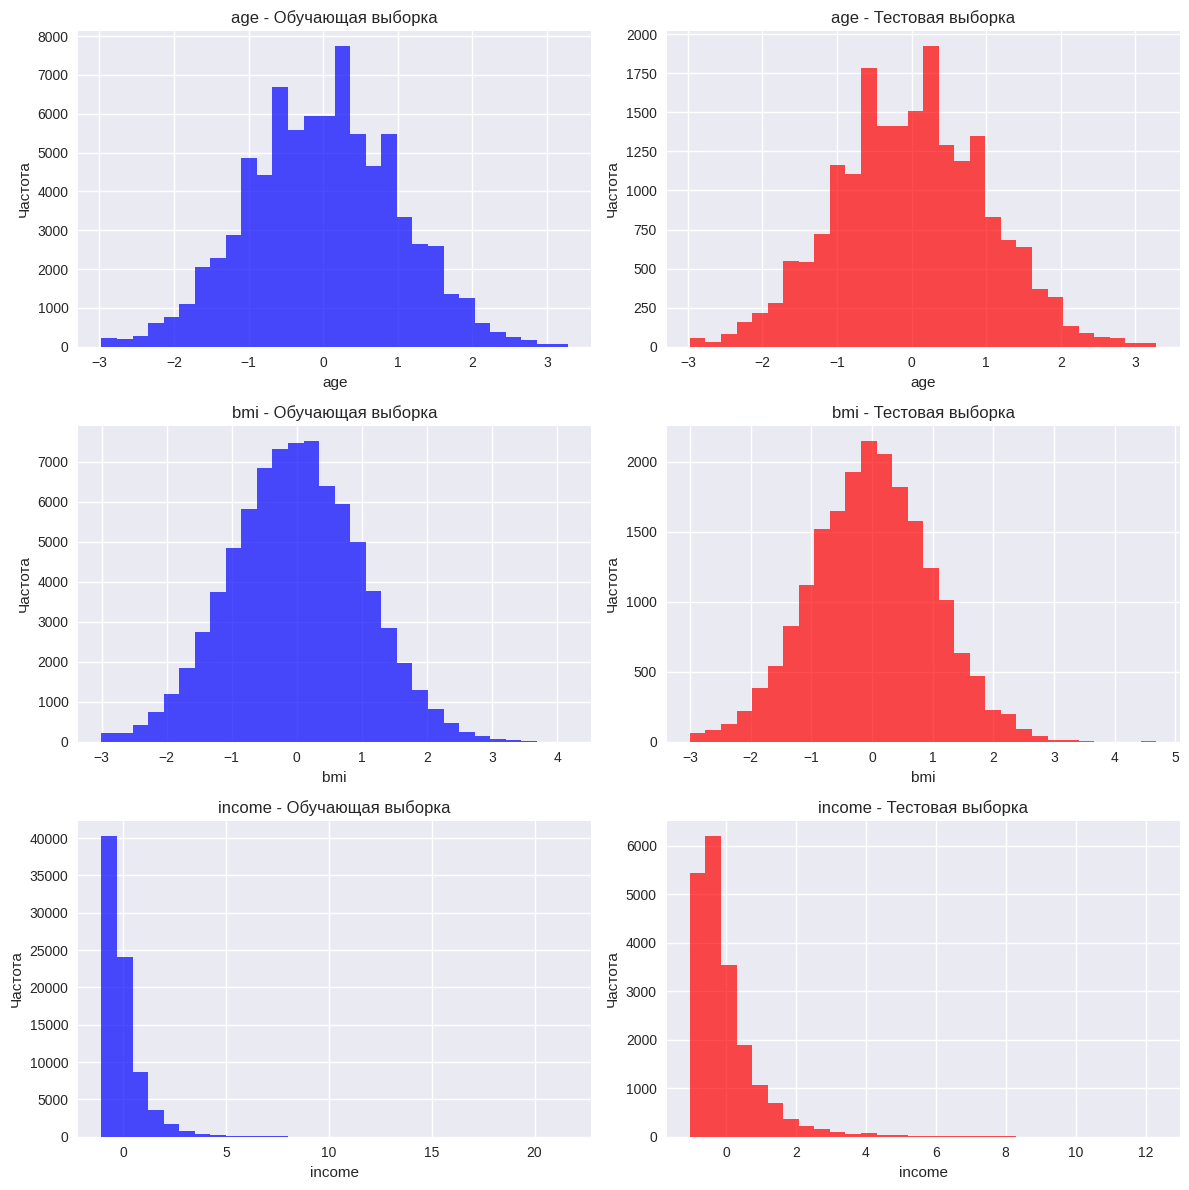

Сравнение средних значений ключевых признаков:


,Train Mean,Test Mean,Difference,Difference (%)
age,0.0002,-0.0007,0.0008,500.0
bmi,0.0007,-0.0028,0.0035,500.0
income,-0.0006,0.0023,-0.0028,500.0


In [27]:
key_features_to_check = ["age", "bmi", "income", "risk_score", "chronic_count"]
key_features_to_check = [f for f in key_features_to_check if f in X.columns]

if key_features_to_check:
  features_to_plot = key_features_to_check[:3]

  fig, axes = plt.subplots(len(features_to_plot), 2,
                           figsize = (12, 4 * len(features_to_plot)))

  for i, feature in enumerate(features_to_plot):
    axes[i, 0].hist(X_train[feature], bins = 30, alpha = 0.7,
                    color="blue", label="Train")
    axes[i, 0].set_title(f"{feature} - Обучающая выборка")
    axes[i, 0].set_xlabel(feature)
    axes[i, 0].set_ylabel("Частота")

    axes[i, 1].hist(X_test[feature], bins = 30, alpha = 0.7,
                    color = "red", label = "Test")
    axes[i, 1].set_title(f"{feature} - Тестовая выборка")
    axes[i, 1].set_xlabel(feature)
    axes[i, 1].set_ylabel("Частота")
  plt.tight_layout()
  plt.show()

  print("Сравнение средних значений ключевых признаков:")
  key_features_stats = pd.DataFrame({
    "Train Mean": X_train[features_to_plot].mean(),
    "Test Mean": X_test[features_to_plot].mean(),
    "Difference": X_train[features_to_plot].mean() - X_test[features_to_plot].mean(),
    "Difference (%)": ((X_train[features_to_plot].mean() - X_test[features_to_plot].mean()) / X_train[features_to_plot].mean() * 100)
  })
  display(key_features_stats.round(4))

# Сохранение

In [28]:
data_split = {
  "X_train": X_train,
  "X_test": X_test,
  "y_train": y_train,
  "y_test": y_test,
  "feature_names": X.columns.tolist()
}

print("Сохраненные данные:")
print(f"- X_train: {data_split["X_train"].shape}")
print(f"- X_test: {data_split["X_test"].shape}")
print(f"- y_train: {data_split["y_train"].shape}")
print(f"- y_test: {data_split["y_test"].shape}")
print(f"- Количество признаков: {len(data_split["feature_names"])}")

feature_names = X.columns.tolist()
print(f"\nПримеры имен признаков: {feature_names[:5]}...")

X_train_final = X_train
X_test_final = X_test
y_train_final = y_train
y_test_final = y_test

Сохраненные данные:
- X_train: (80000, 83)
- X_test: (20000, 83)
- y_train: (80000,)
- y_test: (20000,)
- Количество признаков: 83

Примеры имен признаков: ['person_id', 'age', 'income', 'household_size', 'dependents']...


# Проверка

In [29]:
train_indices = set(X_train.index)
test_indices = set(X_test.index)

intersection = train_indices.intersection(test_indices)
print(f"Пересечение индексов train и test: {len(intersection)}")

if len(intersection) == 0:
  print("Пересечений между train и test нет - разделение корректное")
else:
  print("Обнаружены пересечения между train и test!")

print(f"\nПропущенные значения в обучающей выборке: {X_train.isnull().sum().sum()}")
print(f"Пропущенные значения в тестовой выборке: {X_test.isnull().sum().sum()}")

if X_train.isnull().sum().sum() == 0 and X_test.isnull().sum().sum() == 0:
  print("Пропущенных значений нет")
else:
  print("Обнаружены пропущенные значения")

print(f"\nИтоги разделения:")
print(f"Общий размер данных: {len(X)} samples")
print(f"Обучающая выборка: {len(X_train)} samples ({len(X_train)/len(X) * 100:.1f}%)")
print(f"Тестовая выборка: {len(X_test)} samples ({len(X_test)/len(X) * 100:.1f}%)")
print(f"Признаков: {X_train.shape[1]}")
print(f"Целевая переменная: annual_medical_cost")
print(f"Random state: {RANDOM_STATE} (для воспроизводимости)")

Пересечение индексов train и test: 0
Пересечений между train и test нет - разделение корректное

Пропущенные значения в обучающей выборке: 0
Пропущенные значения в тестовой выборке: 0
Пропущенных значений нет

Итоги разделения:
Общий размер данных: 100000 samples
Обучающая выборка: 80000 samples (80.0%)
Тестовая выборка: 20000 samples (20.0%)
Признаков: 83
Целевая переменная: annual_medical_cost
Random state: 42 (для воспроизводимости)


# **Задача регрессии**
# Подготовка данных

In [30]:
categorical_features = [col for col in X_train_final.columns
                       if any(x in col for x in ["sex", "region", "urban_rural",
                                                 "education", "marital_status",
                                                 "employment_status", "smoker",
                                                 "alcohol_freq"])]

print(f"Категориальные признаки для LightGBM: {len(categorical_features)}")
if categorical_features:
  print(f"Примеры: {categorical_features[:5]}")

train_data = lgb.Dataset(X_train_final, label = y_train_final,
                        categorical_feature = categorical_features,
                        free_raw_data = False)
test_data = lgb.Dataset(X_test_final, label = y_test_final,
                       categorical_feature = categorical_features,
                       free_raw_data = False)

print(f"Размер обучающей выборки: {X_train_final.shape}")
print(f"Размер тестовой выборки: {X_test_final.shape}")

Категориальные признаки для LightGBM: 32
Примеры: ['sex_Female', 'sex_Male', 'sex_Other', 'region_Central', 'region_East']
Размер обучающей выборки: (80000, 83)
Размер тестовой выборки: (20000, 83)


# Обучение модели

In [31]:
params = {
  "objective": "regression",
  "metric": ["mae", "rmse"],
  "boosting_type": "gbdt",
  "num_leaves": 31,
  "learning_rate": 0.05,
  "feature_fraction": 0.9,
  "bagging_fraction": 0.8,
  "bagging_freq": 5,
  "verbose": 0,
  "max_depth": -1,
  "reg_alpha": 0.1,
  "reg_lambda": 0.1,
  "min_child_samples": 20,
  "random_state": 42
}

start_time = time.time()

model = lgb.train(
  params,
  train_data,
  num_boost_round = 1000,
  valid_sets = [test_data],
  valid_names = ["test"],
  callbacks = [
    lgb.early_stopping(stopping_rounds = 50, verbose = True),
    lgb.log_evaluation(period = 100)
  ]
)

training_time = time.time() - start_time
print(f"Обучение завершено за {training_time:.2f} секунд")
print(f"Использовано итераций: {model.best_iteration}")

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
[100]	test's l1: 64.6719	test's rmse: 683.775
Early stopping, best iteration is:
[106]	test's l1: 61.7265	test's rmse: 682.118
Обучение завершено за 4.75 секунд
Использовано итераций: 106


# Прогнозирование и оценка качества

In [32]:
y_pred = model.predict(X_test_final)

mae = mean_absolute_error(y_test_final, y_pred)
mse = mean_squared_error(y_test_final, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_final, y_pred)

mean_actual = y_test_final.mean()
mae_percent = (mae / mean_actual) * 100
rmse_percent = (rmse / mean_actual) * 100

print("Метрики качества на тестовой выборке:")
print(f"MAE (Средняя абсолютная ошибка): {mae:.2f} ({mae_percent:.1f}% от среднего)")
print(f"RMSE (Среднеквадратичная ошибка): {rmse:.2f} ({rmse_percent:.1f}% от среднего)")
print(f"R² (Коэффициент детерминации): {r2:.4f}")

if r2 > 0.7:
  r2_interpretation = "Отличное качество"
elif r2 > 0.5:
  r2_interpretation = "Хорошее качество"
elif r2 > 0.3:
  r2_interpretation = "Удовлетворительное качество"
else:
  r2_interpretation = "Низкое качество"

print(f"Интерпретация R²: {r2_interpretation}")

Метрики качества на тестовой выборке:
MAE (Средняя абсолютная ошибка): 61.73 (2.1% от среднего)
RMSE (Среднеквадратичная ошибка): 682.12 (22.7% от среднего)
R² (Коэффициент детерминации): 0.9540
Интерпретация R²: Отличное качество


# Визуализация

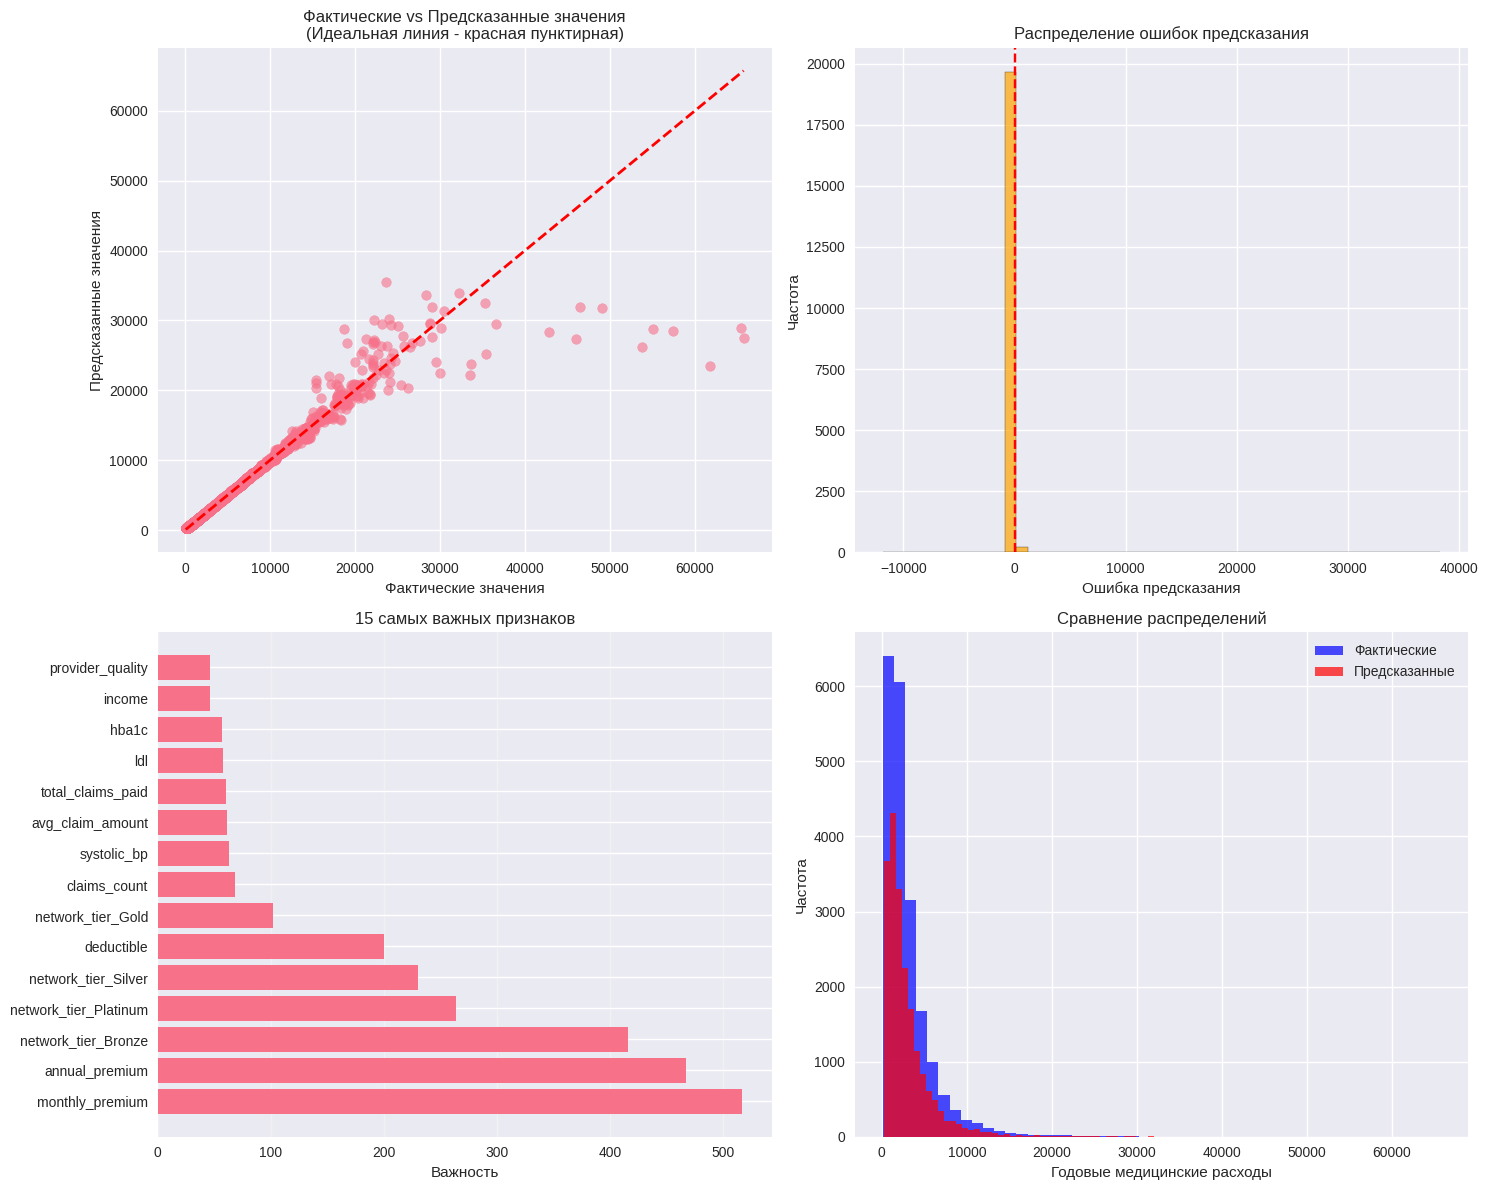

In [33]:
fig, axes = plt.subplots(2, 2, figsize = (15, 12))

axes[0, 0].scatter(y_test_final, y_pred, alpha = 0.6)
axes[0, 0].plot([y_test_final.min(), y_test_final.max()],
                [y_test_final.min(), y_test_final.max()], "r--", lw = 2)
axes[0, 0].set_xlabel("Фактические значения")
axes[0, 0].set_ylabel("Предсказанные значения")
axes[0, 0].set_title("Фактические vs Предсказанные значения\n(Идеальная линия - красная пунктирная)")

errors = y_test_final - y_pred
axes[0, 1].hist(errors, bins = 50, alpha = 0.7,
                color = "orange", edgecolor = "black")
axes[0, 1].axvline(x = 0, color = "red", linestyle = "--")
axes[0, 1].set_xlabel("Ошибка предсказания")
axes[0, 1].set_ylabel("Частота")
axes[0, 1].set_title("Распределение ошибок предсказания")

feature_importance = pd.DataFrame({
  "feature": model.feature_name(),
  "importance": model.feature_importance()
}).sort_values("importance", ascending = False)

top_features = feature_importance.head(15)
axes[1, 0].barh(top_features["feature"], top_features["importance"])
axes[1, 0].set_xlabel("Важность")
axes[1, 0].set_title("15 самых важных признаков")
axes[1, 0].grid(axis = 'x', alpha = 0.3)

axes[1, 1].hist(y_test_final, bins = 50, alpha = 0.7,
                label = "Фактические", color = "blue")
axes[1, 1].hist(y_pred, bins = 50, alpha = 0.7,
                label = "Предсказанные", color = "red")
axes[1, 1].set_xlabel("Годовые медицинские расходы")
axes[1, 1].set_ylabel("Частота")
axes[1, 1].set_title("Сравнение распределений")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Анализ

10 самых важных признаков:


,feature,importance
21,monthly_premium,517
20,annual_premium,467
79,network_tier_Bronze,416
81,network_tier_Platinum,264
82,network_tier_Silver,230
14,deductible,200
80,network_tier_Gold,102
22,claims_count,68
10,systolic_bp,63
23,avg_claim_amount,61



Важность признаков по категориям:
  Прочие: 41.9%
  Страховые параметры: 37.8%
  Здоровье/Биометрия: 8.3%
  История обращений: 7.9%
  Социально-экономические: 1.4%
  Демография: 1.2%
  Образ жизни: 1.2%
  Хронические заболевания: 0.5%


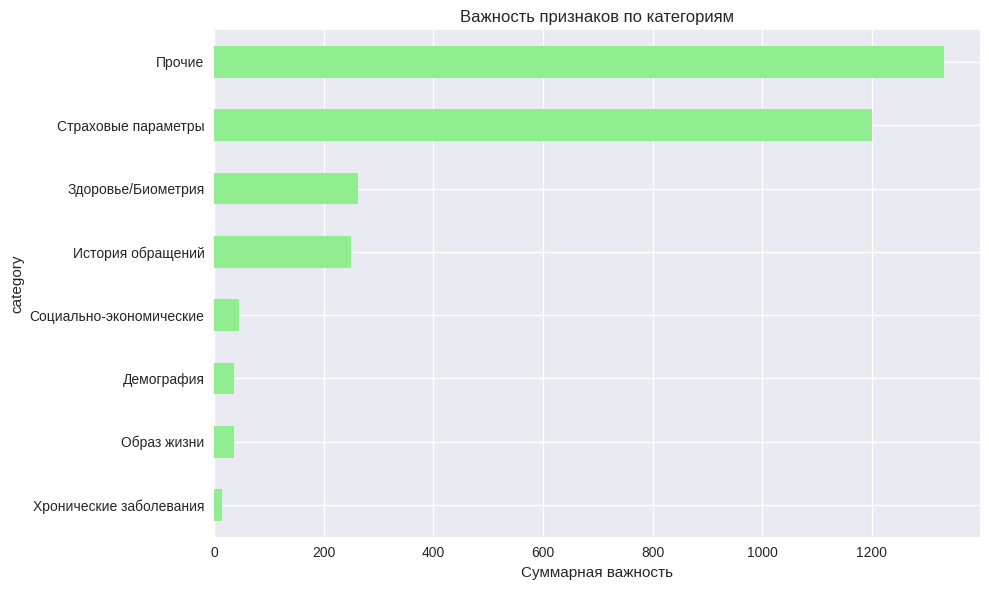

In [34]:
print("10 самых важных признаков:")
display(feature_importance.head(10))

def categorize_feature(feature_name):
  if "age" in feature_name:
    return "Демография"
  elif "bmi" in feature_name or any(x in feature_name for x in ["bp", "ldl", "hba1c"]):
    return "Здоровье/Биометрия"
  elif "income" in feature_name:
    return "Социально-экономические"
  elif any(x in feature_name for x in ["chronic", "hypertension", "diabetes", "asthma"]):
    return "Хронические заболевания"
  elif any(x in feature_name for x in ["smoker", "alcohol"]):
    return "Образ жизни"
  elif any(x in feature_name for x in ["visits", "hospital", "medication", "claim"]):
    return "История обращений"
  elif any(x in feature_name for x in ["plan", "premium", "deductible"]):
    return "Страховые параметры"
  else:
    return "Прочие"

feature_importance["category"] = feature_importance["feature"].apply(categorize_feature)
category_importance = feature_importance.groupby("category")["importance"].sum().sort_values(ascending = False)

print("\nВажность признаков по категориям:")
for category, importance in category_importance.items():
  percentage = (importance / category_importance.sum()) * 100
  print(f"  {category}: {percentage:.1f}%")

plt.figure(figsize=(10, 6))
category_importance.plot(kind = "barh", color = "lightgreen")
plt.xlabel("Суммарная важность")
plt.title("Важность признаков по категориям")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Кросс-валидация и сравнение с базовыми моделями

Сравнение моделей (кросс-валидация по MAE):
  LightGBM: 57.39 ± 3.62
  Random Forest: 10.68 ± 1.33
  Ridge Regression: 317.14 ± 2.01


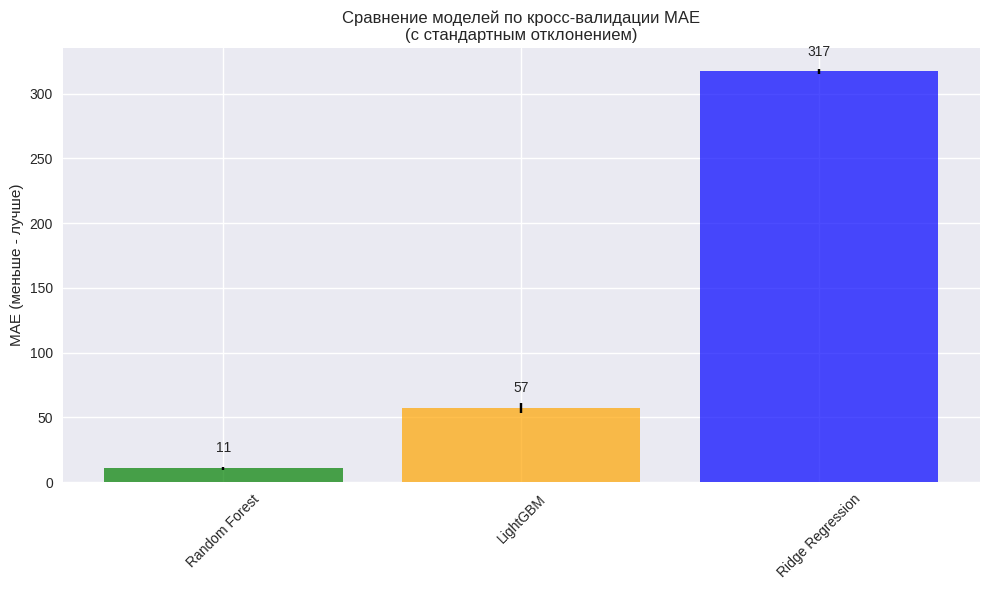

In [35]:
models = {
  "LightGBM": LGBMRegressor(**params),
  "Random Forest": RandomForestRegressor(n_estimators = 100, random_state = 42,
                                         n_jobs = -1),
  "Ridge Regression": Ridge(alpha = 1.0)
}

print("Сравнение моделей (кросс-валидация по MAE):")
cv_results = {}

for name, model_obj in models.items():
  try:
    cv_scores = cross_val_score(model_obj, X_train_final, y_train_final,
      cv = 3, scoring = "neg_mean_absolute_error", n_jobs = -1)
    cv_mae = -cv_scores.mean()
    cv_std = cv_scores.std()

    cv_results[name] = {"mean": cv_mae, "std": cv_std}
    print(f"  {name}: {cv_mae:.2f} ± {cv_std:.2f}")

  except Exception as e:
    print(f"  Ошибка при кросс-валидации {name}: {e}")
    cv_results[name] = {"mean": None, "std": None}
plt.figure(figsize = (10, 6))
models_compare = pd.DataFrame({
  "Model": list(cv_results.keys()),
  "MAE": [result["mean"] for result in cv_results.values()],
  "Std": [result["std"] for result in cv_results.values()]
}).sort_values("MAE")

bars = plt.bar(models_compare["Model"], models_compare["MAE"],
               color = ["green", "orange", "blue"],
               yerr = models_compare["Std"], capsize = 5, alpha = 0.7)

plt.ylabel("MAE (меньше - лучше)")
plt.title("Сравнение моделей по кросс-валидации MAE\n(с стандартным отклонением)")
plt.xticks(rotation = 45)

for bar, value in zip(bars, models_compare["MAE"]):
  if value is not None:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 10,
            f"{value:.0f}", ha = "center", va = "bottom")

plt.tight_layout()
plt.show()

# **Подбор оптимальных значений**
# Подготовка данных

In [36]:
SAMPLE_SIZE = 20000

if len(X_train_final) > SAMPLE_SIZE:
  np.random.seed(42)
  sample_indices = np.random.choice(len(X_train_final), SAMPLE_SIZE,
                                    replace = False)
  X_tune = X_train_final.iloc[sample_indices]
  y_tune = y_train_final.iloc[sample_indices]
else:
  X_tune = X_train_final
  y_tune = y_train_final

print(f"Размер выборки для подбора гиперпараметров: {len(X_tune)} samples")
print(f"Признаков: {X_tune.shape[1]}")

Размер выборки для подбора гиперпараметров: 20000 samples
Признаков: 83


# Выбор гиперпараметров

In [37]:
param_grid = {
  "num_leaves": [31, 63, 127],
  "learning_rate": [0.01, 0.05, 0.1],
  "max_depth": [6, 8, -1],
  "min_child_samples": [10, 20, 30],
  "subsample": [0.8, 0.9, 1.0],
  "colsample_bytree": [0.8, 0.9, 1.0],
  "reg_alpha": [0, 0.1, 0.5],
  "reg_lambda": [0, 0.1, 0.5]
}

print("Пространство гиперпараметров для поиска:")
for param, values in param_grid.items():
  print(f"  {param}: {values}")

print(f"\nОбщее количество комбинаций: {np.prod([len(v) for v in param_grid.values()])}")

Пространство гиперпараметров для поиска:
  num_leaves: [31, 63, 127]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [6, 8, -1]
  min_child_samples: [10, 20, 30]
  subsample: [0.8, 0.9, 1.0]
  colsample_bytree: [0.8, 0.9, 1.0]
  reg_alpha: [0, 0.1, 0.5]
  reg_lambda: [0, 0.1, 0.5]

Общее количество комбинаций: 6561


# Настройка и запуск Randomized Search

In [38]:
base_params = {
  "objective": "regression",
  "metric": "mae",
  "random_state": 42,
  "n_jobs": -1,
  "verbose": -1
}

lgb_model = LGBMRegressor(**base_params)
random_search = RandomizedSearchCV(
  estimator = lgb_model,
  param_distributions = param_grid,
  n_iter = 20,
  cv = 3,
  scoring = "neg_mean_absolute_error",
  random_state = 42,
  n_jobs = -1,
  verbose = 1
)

print("Начало подбора гиперпараметров...")
start_time = time.time()

random_search.fit(X_tune, y_tune)

search_time = time.time() - start_time
print(f"Подбор завершен за {search_time / 60:.2f} минут")

print("\nЛучшие параметры:")
best_params = random_search.best_params_
for param, value in best_params.items():
  print(f"  {param}: {value}")

print(f"\nЛучшая оценка (MAE): {-random_search.best_score_:.2f}")

Начало подбора гиперпараметров...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Подбор завершен за 2.86 минут

Лучшие параметры:
  subsample: 0.9
  reg_lambda: 0
  reg_alpha: 0.1
  num_leaves: 127
  min_child_samples: 20
  max_depth: -1
  learning_rate: 0.05
  colsample_bytree: 1.0

Лучшая оценка (MAE): 54.25


# Сравнение с моделью

Сравнение метрик:


,Метрика,До настройки,После настройки,Улучшение (%)
0,MAE,61.7265,50.6204,17.9925
1,RMSE,682.1180,680.0683,0.3005
2,R²,0.9540,0.9543,0.0289


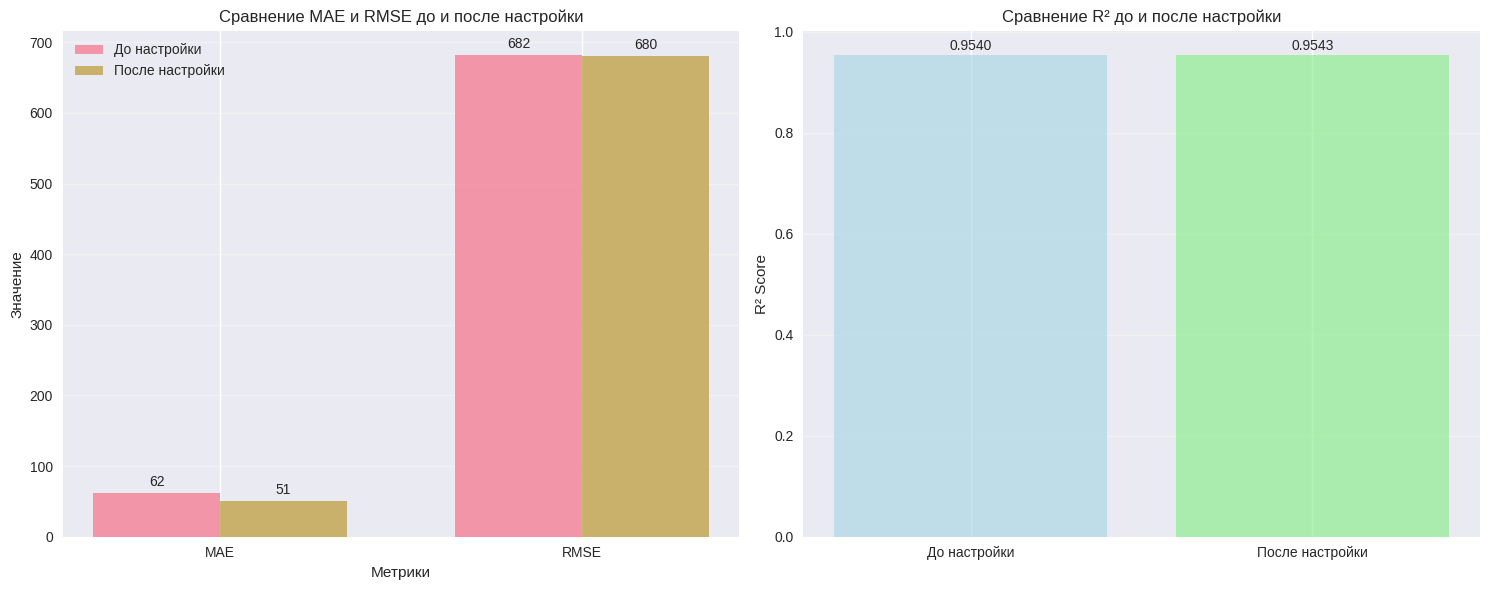

In [39]:
final_params = base_params.copy()
final_params.update(best_params)

final_model = LGBMRegressor(**final_params)
final_model.fit(X_train_final, y_train_final)

y_pred_tuned = final_model.predict(X_test_final)

mae_tuned = mean_absolute_error(y_test_final, y_pred_tuned)
mae_original = mean_absolute_error(y_test_final, y_pred)

rmse_tuned = np.sqrt(mean_squared_error(y_test_final, y_pred_tuned))
rmse_original = np.sqrt(mean_squared_error(y_test_final, y_pred))

r2_tuned = r2_score(y_test_final, y_pred_tuned)
r2_original = r2_score(y_test_final, y_pred)

improvement_mae = ((mae_original - mae_tuned) / mae_original) * 100
improvement_rmse = ((rmse_original - rmse_tuned) / rmse_original) * 100
improvement_r2 = ((r2_tuned - r2_original) / abs(r2_original)) * 100

print("Сравнение метрик:")
comparison_df = pd.DataFrame({
  "Метрика": ["MAE", "RMSE", "R²"],
  "До настройки": [mae_original, rmse_original, r2_original],
  "После настройки": [mae_tuned, rmse_tuned, r2_tuned],
  "Улучшение (%)": [improvement_mae, improvement_rmse, improvement_r2]
})

display(comparison_df.round(4))

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

metrics_before = [mae_original, rmse_original]
metrics_after = [mae_tuned, rmse_tuned]
metric_names = ["MAE", "RMSE"]

x = np.arange(len(metric_names))
width = 0.35

axes[0].bar(x - width/2, metrics_before, width,
            label = "До настройки", alpha = 0.7)
axes[0].bar(x + width/2, metrics_after, width,
            label = "После настройки", alpha = 0.7)
axes[0].set_xlabel("Метрики")
axes[0].set_ylabel("Значение")
axes[0].set_title("Сравнение MAE и RMSE до и после настройки")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metric_names)
axes[0].legend()
axes[0].grid(axis = 'y', alpha = 0.3)

for i, (before, after) in enumerate(zip(metrics_before, metrics_after)):
  axes[0].text(i - width/2, before + 10, f"{before:.0f}", ha = "center")
  axes[0].text(i + width/2, after + 10, f"{after:.0f}", ha = "center")

axes[1].bar(["До настройки", "После настройки"], [r2_original, r2_tuned],
           color=["lightblue", "lightgreen"], alpha = 0.7)
axes[1].set_ylabel("R² Score")
axes[1].set_title("Сравнение R² до и после настройки")
axes[1].grid(axis = 'y', alpha = 0.3)

for i, value in enumerate([r2_original, r2_tuned]):
  axes[1].text(i, value + 0.01, f"{value:.4f}", ha = "center")

plt.tight_layout()
plt.show()

# Анализ результатов

5 лучших комбинаций гиперпараметров:


,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_min_child_samples,param_max_depth,param_learning_rate,param_colsample_bytree,mean_test_score,std_test_score,rank_test_score
6,0.9,0.0,0.1,127,20,-1,0.05,1.0,54.2529,6.2593,1
1,1.0,0.5,0.1,63,10,8,0.05,1.0,54.4952,6.8660,2
12,0.8,0.1,0.5,127,20,8,0.10,1.0,54.8392,5.4650,3
11,0.9,0.5,0.1,127,30,8,0.05,1.0,55.7789,6.4359,4
7,0.9,0.0,0.0,63,30,8,0.10,1.0,56.8691,6.9852,5


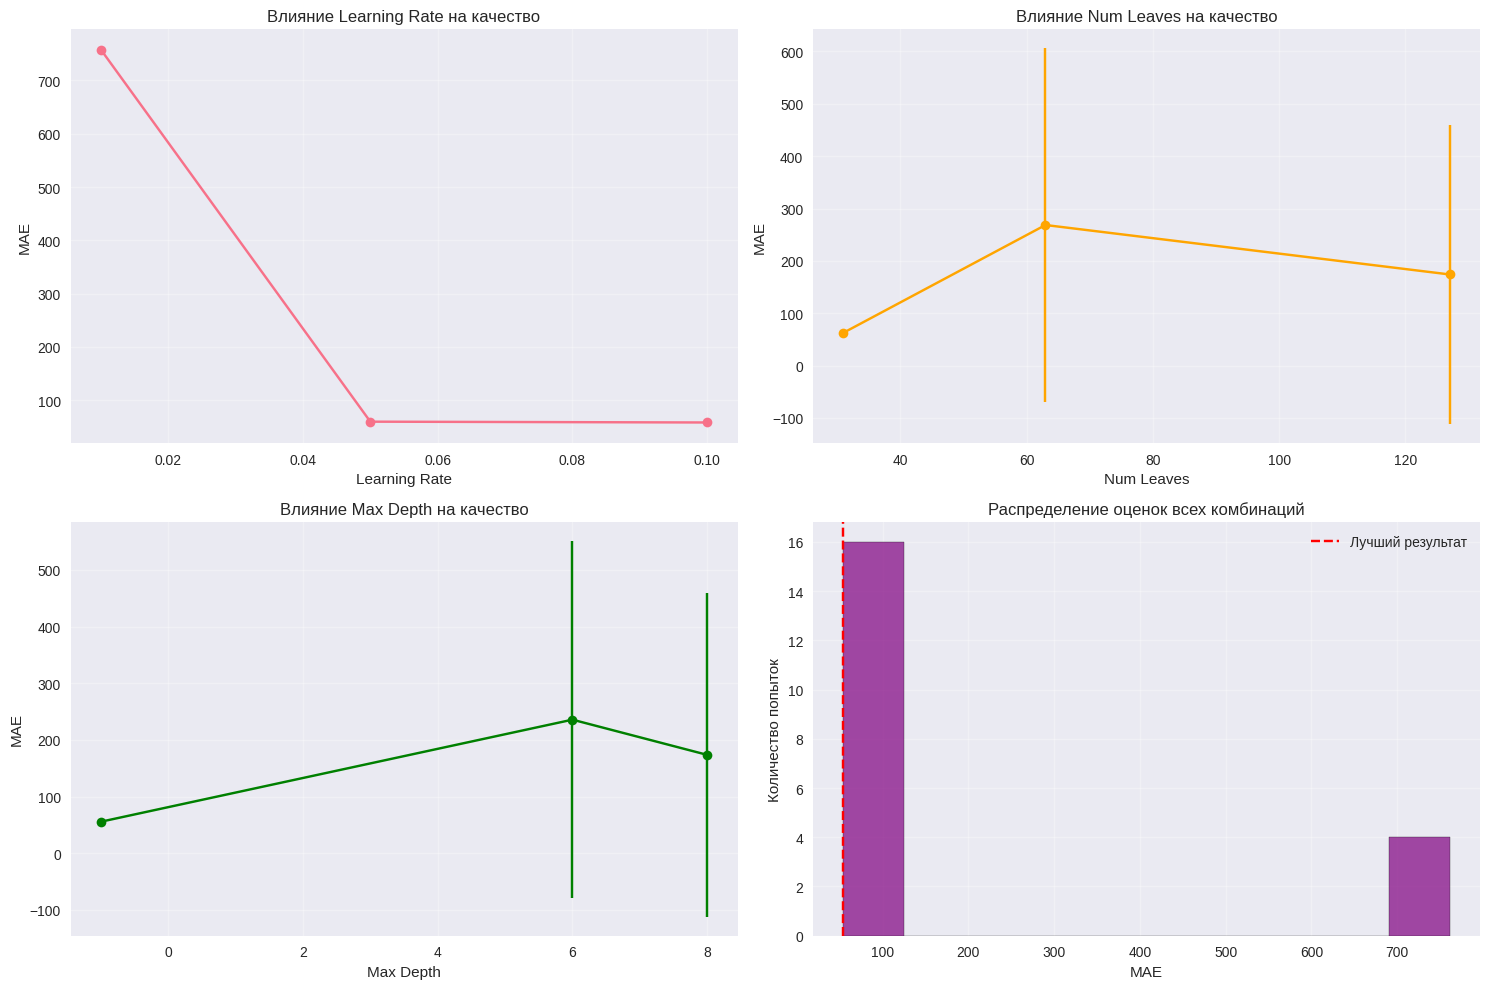

In [40]:
results_df = pd.DataFrame(random_search.cv_results_)

important_columns = [col for col in results_df.columns if
                     col.startswith("param_") or col in ["mean_test_score",
                                                         "std_test_score",
                                                         "rank_test_score"]]
results_analysis = results_df[important_columns].copy()
results_analysis["mean_test_score"] = -results_analysis["mean_test_score"]

print("5 лучших комбинаций гиперпараметров:")
top_5_results = results_analysis.nsmallest(5, "mean_test_score")
display(top_5_results.round(4))

fig, axes = plt.subplots(2, 2, figsize = (15, 10))

learning_rate_results = results_analysis.groupby("param_learning_rate")["mean_test_score"].agg(["mean", "std"])
axes[0, 0].errorbar(learning_rate_results.index, learning_rate_results["mean"],
                    yerr = learning_rate_results["std"], fmt = "o-",
                    capsize = 5)
axes[0, 0].set_xlabel("Learning Rate")
axes[0, 0].set_ylabel("MAE")
axes[0, 0].set_title("Влияние Learning Rate на качество")
axes[0, 0].grid(True, alpha = 0.3)

num_leaves_results = results_analysis.groupby("param_num_leaves")["mean_test_score"].agg(["mean", "std"])
axes[0, 1].errorbar(num_leaves_results.index, num_leaves_results["mean"],
                    yerr = num_leaves_results["std"], fmt = "o-", capsize = 5,
                    color = "orange")
axes[0, 1].set_xlabel("Num Leaves")
axes[0, 1].set_ylabel("MAE")
axes[0, 1].set_title("Влияние Num Leaves на качество")
axes[0, 1].grid(True, alpha = 0.3)

max_depth_results = results_analysis.groupby("param_max_depth")["mean_test_score"].agg(["mean", "std"])
axes[1, 0].errorbar(max_depth_results.index, max_depth_results["mean"],
                    yerr = max_depth_results["std"], fmt = "o-", capsize = 5,
                    color = "green")
axes[1, 0].set_xlabel("Max Depth")
axes[1, 0].set_ylabel("MAE")
axes[1, 0].set_title("Влияние Max Depth на качество")
axes[1, 0].grid(True, alpha = 0.3)

axes[1, 1].hist(results_analysis["mean_test_score"], bins = 10, alpha = 0.7,
                color = "purple", edgecolor = "black")
axes[1, 1].axvline(results_analysis["mean_test_score"].min(), color = "red",
                   linestyle = "--", label = "Лучший результат")
axes[1, 1].set_xlabel("MAE")
axes[1, 1].set_ylabel("Количество попыток")
axes[1, 1].set_title("Распределение оценок всех комбинаций")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

# Выводы

In [41]:
if improvement_mae > 0:
  print(f"Качество модели улучшилось на {improvement_mae:.2f}%")
  print(f"   Снижение MAE: {mae_original - mae_tuned:.2f}")
  print(f"   Улучшение R²: {improvement_r2:.2f}%")
else:
  print(f"Качество не улучшилось. Лучшие параметры уже были подобраны.")

print("\nКлючевые изменения:")
key_params = ["num_leaves", "learning_rate", "max_depth", "min_child_samples"]
default_params = {
  "num_leaves": 31,
  "learning_rate": 0.05,
  "max_depth": -1,
  "min_child_samples": 20
}

for param in key_params:
  default_val = default_params.get(param, "N/A")
  tuned_val = best_params.get(param, "N/A")
  print(f"   {param}: {default_val} - {tuned_val}")

print("\nФинальные метрики:")
print(f"   MAE: {mae_tuned:.2f}")
print(f"   RMSE: {rmse_tuned:.2f}")
print(f"   R²: {r2_tuned:.4f}")

best_lgb_model = final_model

Качество модели улучшилось на 17.99%
   Снижение MAE: 11.11
   Улучшение R²: 0.03%

Ключевые изменения:
   num_leaves: 31 - 127
   learning_rate: 0.05 - 0.05
   max_depth: -1 - -1
   min_child_samples: 20 - 20

Финальные метрики:
   MAE: 50.62
   RMSE: 680.07
   R²: 0.9543


# **Вычисление ошибок**
# Вычисление прогнозов

In [42]:
y_train_pred = best_lgb_model.predict(X_train_final)
y_test_pred = best_lgb_model.predict(X_test_final)

train_mae = mean_absolute_error(y_train_final, y_train_pred)
train_mse = mean_squared_error(y_train_final, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_final, y_train_pred)

test_mae = mean_absolute_error(y_test_final, y_test_pred)
test_mse = mean_squared_error(y_test_final, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_final, y_test_pred)

mae_gap = train_mae - test_mae
rmse_gap = train_rmse - test_rmse
r2_gap = train_r2 - test_r2

mae_gap_percent = (mae_gap / train_mae) * 100
rmse_gap_percent = (rmse_gap / train_rmse) * 100

print("Метрики качества:")
print(f"{"Метрика":<10} {"Обучающая":<12} {"Тестовая":<12} {"Разница":<12} {"Разница (%)":<12}")
print("-" * 65)
print(f"{"MAE":<10} {train_mae:<11.2f} {test_mae:<11.2f} {mae_gap:<11.2f} {mae_gap_percent:<11.2f}")
print(f"{"RMSE":<10} {train_rmse:<11.2f} {test_rmse:<11.2f} {rmse_gap:<11.2f} {rmse_gap_percent:<11.2f}")
print(f"{"R²":<10} {train_r2:<11.4f} {test_r2:<11.4f} {r2_gap:<11.4f} {"N/A":<11}")

Метрики качества:
Метрика    Обучающая    Тестовая     Разница      Разница (%) 
-----------------------------------------------------------------
MAE        29.48       50.62       -21.14      -71.73     
RMSE       220.53      680.07      -459.53     -208.37    
R²         0.9950      0.9543      0.0407      N/A        


# Визуализация

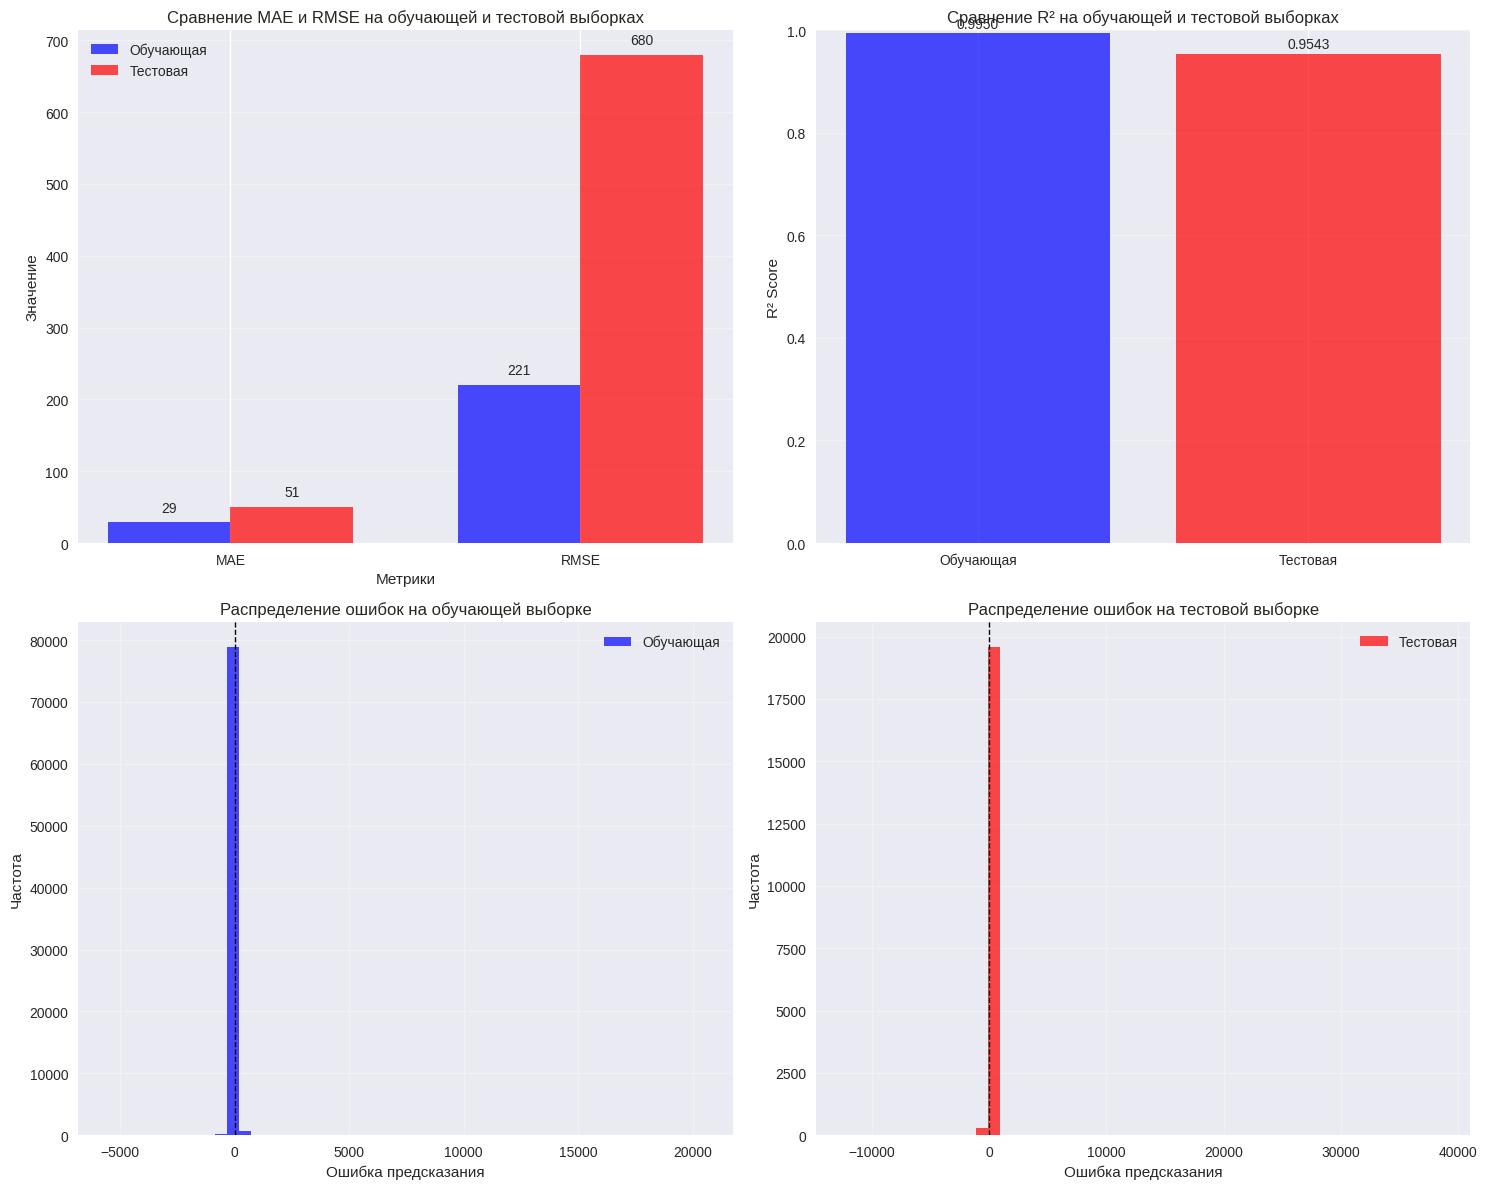

In [43]:
fig, axes = plt.subplots(2, 2, figsize = (15, 12))

metrics = ["MAE", "RMSE"]
train_metrics = [train_mae, train_rmse]
test_metrics = [test_mae, test_rmse]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width / 2, train_metrics, width,
                       label = "Обучающая", alpha = 0.7, color = "blue")
bars2 = axes[0, 0].bar(x + width / 2, test_metrics, width,
                       label = "Тестовая", alpha = 0.7, color = "red")

axes[0, 0].set_xlabel("Метрики")
axes[0, 0].set_ylabel("Значение")
axes[0, 0].set_title("Сравнение MAE и RMSE на обучающей и тестовой выборках")
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics)
axes[0, 0].legend()
axes[0, 0].grid(axis = 'y', alpha = 0.3)

for bars in [bars1, bars2]:
  for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2, height + 10,
                    f"{height:.0f}", ha = "center", va = "bottom")

axes[0, 1].bar(["Обучающая", "Тестовая"], [train_r2, test_r2],
               color = ["blue", "red"], alpha = 0.7)
axes[0, 1].set_ylabel("R² Score")
axes[0, 1].set_title("Сравнение R² на обучающей и тестовой выборках")
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis = 'y', alpha = 0.3)

for i, value in enumerate([train_r2, test_r2]):
  axes[0, 1].text(i, value + 0.01, f"{value:.4f}", ha = "center")

train_errors = y_train_final - y_train_pred
axes[1, 0].hist(train_errors, bins = 50, alpha = 0.7,
                color = "blue", label = "Обучающая")
axes[1, 0].axvline(x = 0, color = "black", linestyle = "--", linewidth = 1)
axes[1, 0].set_xlabel("Ошибка предсказания")
axes[1, 0].set_ylabel("Частота")
axes[1, 0].set_title("Распределение ошибок на обучающей выборке")
axes[1, 0].legend()
axes[1, 0].grid(alpha = 0.3)

test_errors = y_test_final - y_test_pred
axes[1, 1].hist(test_errors, bins = 50, alpha = 0.7,
                color = "red", label = "Тестовая")
axes[1, 1].axvline(x = 0, color = "black", linestyle = "--", linewidth = 1)
axes[1, 1].set_xlabel("Ошибка предсказания")
axes[1, 1].set_ylabel("Частота")
axes[1, 1].set_title("Распределение ошибок на тестовой выборке")
axes[1, 1].legend()
axes[1, 1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

# Анализ распределения ошибок

,Статистика,Обучающая выборка,Тестовая выборка
0,Среднее,0.0001,6.7452
1,Стандартное отклонение,220.5347,680.0518
2,Медиана,-5.5118,-5.5913
3,Асимметрия,34.5767,37.8127
4,Эксцесс,2467.6598,1899.0216
5,Минимум,-5526.9990,-12249.7447
6,Максимум,20432.3115,38486.9157


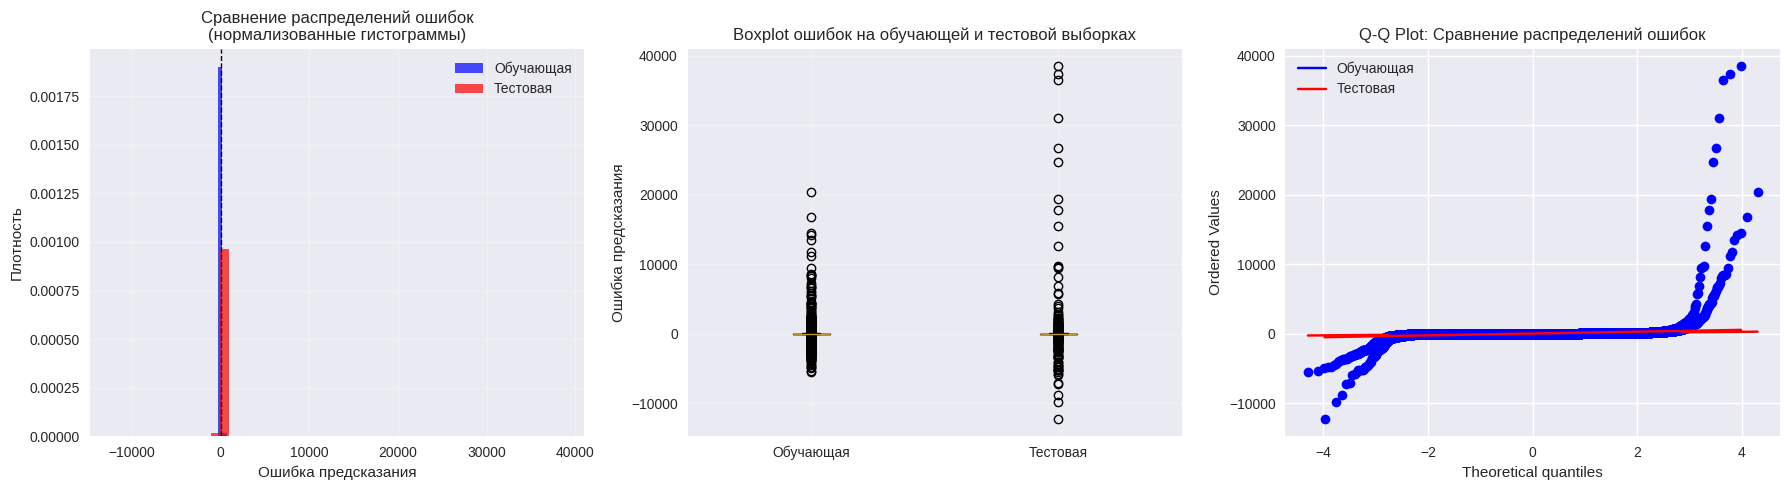


Тест на нормальность ошибок:
Обучающая выборка: p-value = 0.0000
Тестовая выборка: p-value = 0.0000
Ошибки не распределены нормально на обеих выборках


In [44]:
error_stats = pd.DataFrame({
  "Статистика": ["Среднее", "Стандартное отклонение", "Медиана", "Асимметрия",
                "Эксцесс", "Минимум", "Максимум"],
  "Обучающая выборка": [train_errors.mean(), train_errors.std(),
                        train_errors.median(), train_errors.skew(),
                        train_errors.kurtosis(), train_errors.min(),
                        train_errors.max()],
  "Тестовая выборка": [test_errors.mean(), test_errors.std(),
                       test_errors.median(), test_errors.skew(),
                       test_errors.kurtosis(), test_errors.min(),
                       test_errors.max()]
})

display(error_stats.round(4))

fig, axes = plt.subplots(1, 3, figsize = (18, 5))

axes[0].hist(train_errors, bins = 50, alpha = 0.7, density = True,
             color = "blue", label = "Обучающая")
axes[0].hist(test_errors, bins = 50, alpha = 0.7, density = True,
             color = "red", label = "Тестовая")
axes[0].axvline(x = 0, color = "black", linestyle = "--", linewidth = 1)
axes[0].set_xlabel("Ошибка предсказания")
axes[0].set_ylabel("Плотность")
axes[0].set_title("Сравнение распределений ошибок\n(нормализованные гистограммы)")
axes[0].legend()
axes[0].grid(alpha = 0.3)

boxplot_data = [train_errors, test_errors]
axes[1].boxplot(boxplot_data, labels = ["Обучающая", "Тестовая"])
axes[1].set_ylabel("Ошибка предсказания")
axes[1].set_title("Boxplot ошибок на обучающей и тестовой выборках")
axes[1].grid(alpha = 0.3)

stats.probplot(train_errors, dist = "norm", plot = axes[2])
stats.probplot(test_errors, dist = "norm", plot = axes[2])
axes[2].set_title("Q-Q Plot: Сравнение распределений ошибок")
axes[2].plot([], [], "b-", label = "Обучающая")
axes[2].plot([], [], "r-", label = "Тестовая")
axes[2].legend()

plt.tight_layout()
plt.show()

_, train_norm_p = normaltest(train_errors)
_, test_norm_p = normaltest(test_errors)

print("\nТест на нормальность ошибок:")
print(f"Обучающая выборка: p-value = {train_norm_p:.4f}")
print(f"Тестовая выборка: p-value = {test_norm_p:.4f}")

if train_norm_p > 0.05 and test_norm_p > 0.05:
  print("Ошибки распределены нормально на обеих выборках")
elif train_norm_p > 0.05:
  print("Ошибки распределены нормально только на обучающей выборке")
elif test_norm_p > 0.05:
  print("Ошибки распределены нормально только на тестовой выборке")
else:
  print("Ошибки не распределены нормально на обеих выборках")

# Анализ поведения модели

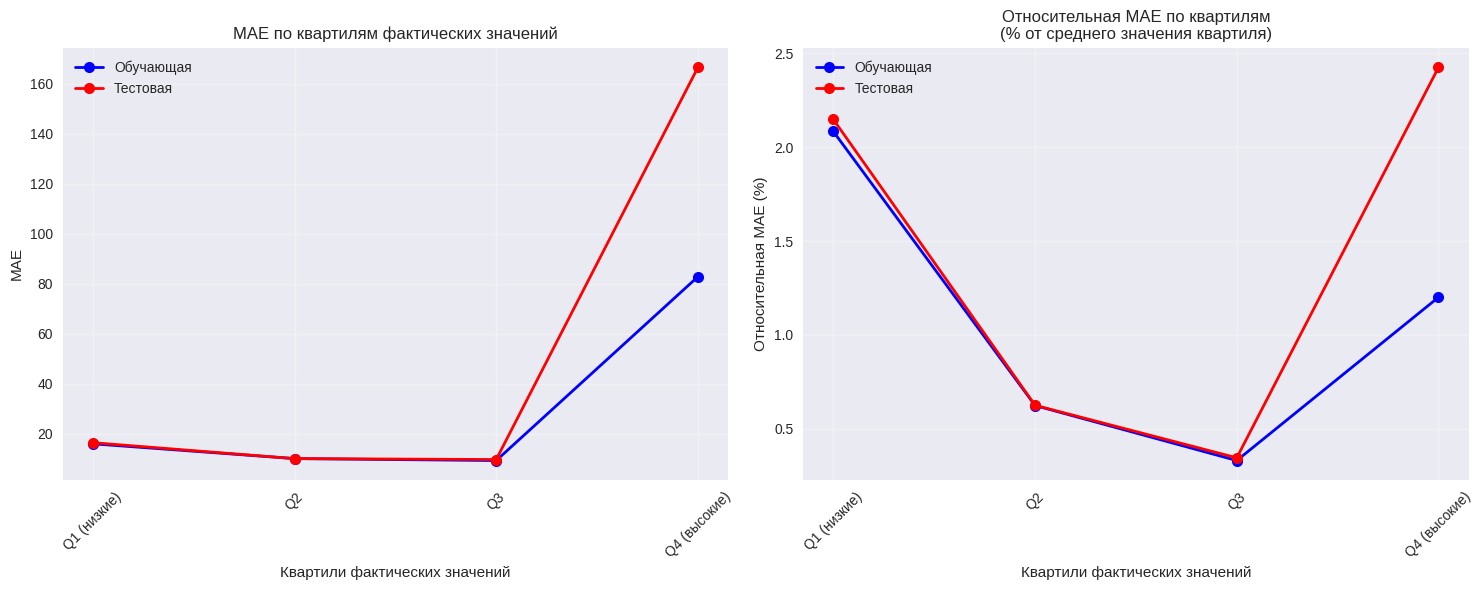

Анализ ошибок:

Q1 (низкие):
  Обучающая: 15.91 (2.1%)
  Тестовая:  16.36 (2.1%)
  Разница:   0.45

Q2:
  Обучающая: 10.00 (0.6%)
  Тестовая:  9.99 (0.6%)
  Разница:   -0.01

Q3:
  Обучающая: 9.22 (0.3%)
  Тестовая:  9.63 (0.3%)
  Разница:   0.41

Q4 (высокие):
  Обучающая: 82.77 (1.2%)
  Тестовая:  166.49 (2.4%)
  Разница:   83.72


In [45]:
y_train_bins = pd.qcut(y_train_final, q = 4,
                       labels = ["Q1 (низкие)", "Q2", "Q3", "Q4 (высокие)"])
y_test_bins = pd.qcut(y_test_final, q = 4,
                      labels = ["Q1 (низкие)", "Q2", "Q3", "Q4 (высокие)"])

train_mae_by_quantile = []
test_mae_by_quantile = []

for bin_label in ["Q1 (низкие)", "Q2", "Q3", "Q4 (высокие)"]:
  train_mask = y_train_bins == bin_label
  test_mask = y_test_bins == bin_label

  if train_mask.any():
    train_mae_bin = mean_absolute_error(y_train_final[train_mask], y_train_pred[train_mask])
    train_mae_by_quantile.append(train_mae_bin)

  if test_mask.any():
    test_mae_bin = mean_absolute_error(y_test_final[test_mask], y_test_pred[test_mask])
    test_mae_by_quantile.append(test_mae_bin)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

quantile_labels = ["Q1 (низкие)", "Q2", "Q3", "Q4 (высокие)"]
x = np.arange(len(quantile_labels))

axes[0].plot(x, train_mae_by_quantile, "bo-", label = "Обучающая",
             linewidth = 2, markersize = 8)
axes[0].plot(x, test_mae_by_quantile, "ro-", label = "Тестовая",
             linewidth = 2, markersize = 8)
axes[0].set_xlabel("Квартили фактических значений")
axes[0].set_ylabel("MAE")
axes[0].set_title("MAE по квартилям фактических значений")
axes[0].set_xticks(x)
axes[0].set_xticklabels(quantile_labels, rotation = 45)
axes[0].legend()
axes[0].grid(alpha = 0.3)

train_relative_mae = [mae / y_train_final[y_train_bins == label].mean() * 100
                      for mae, label in zip(train_mae_by_quantile, quantile_labels)]
test_relative_mae = [mae / y_test_final[y_test_bins == label].mean() * 100
                     for mae, label in zip(test_mae_by_quantile, quantile_labels)]

axes[1].plot(x, train_relative_mae, "bo-", label = "Обучающая",
             linewidth = 2, markersize = 8)
axes[1].plot(x, test_relative_mae, "ro-", label = "Тестовая",
             linewidth = 2, markersize = 8)
axes[1].set_xlabel("Квартили фактических значений")
axes[1].set_ylabel("Относительная MAE (%)")
axes[1].set_title("Относительная MAE по квартилям\n(% от среднего значения квартиля)")
axes[1].set_xticks(x)
axes[1].set_xticklabels(quantile_labels, rotation=45)
axes[1].legend()
axes[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

print("Анализ ошибок:")
for i, (q_label, train_mae_q, test_mae_q, train_rel, test_rel) in enumerate(zip(
    quantile_labels, train_mae_by_quantile, test_mae_by_quantile,
    train_relative_mae, test_relative_mae)):

  print(f"\n{q_label}:")
  print(f"  Обучающая: {train_mae_q:.2f} ({train_rel:.1f}%)")
  print(f"  Тестовая:  {test_mae_q:.2f} ({test_rel:.1f}%)")
  print(f"  Разница:   {test_mae_q - train_mae_q:.2f}")

# Вывод

In [46]:
print("Оценка качества модели:")

if test_r2 > 0.8:
  quality_assessment = "Отличное"
elif test_r2 > 0.6:
  quality_assessment = "Хорошее"
elif test_r2 > 0.4:
  quality_assessment = "Удовлетворительное"
else:
  quality_assessment = "Низкое"

print(f"Качество модели (R²): {quality_assessment} ({test_r2:.4f})")
print(f"Средняя ошибка (MAE): {test_mae:.2f} ({(test_mae/y_test_final.mean())*100:.1f}% от средних расходов)")

print(f"Разница R² между train и test: {r2_gap:.4f}")
print(f"Разница MAE между train и test: {mae_gap_percent:.2f}%")

Оценка качества модели:
Качество модели (R²): Отличное (0.9543)
Средняя ошибка (MAE): 50.62 (1.7% от средних расходов)
Разница R² между train и test: 0.0407
Разница MAE между train и test: -71.73%


# **Борьба с асимметрией распределения и выбросами**
# Диагностика

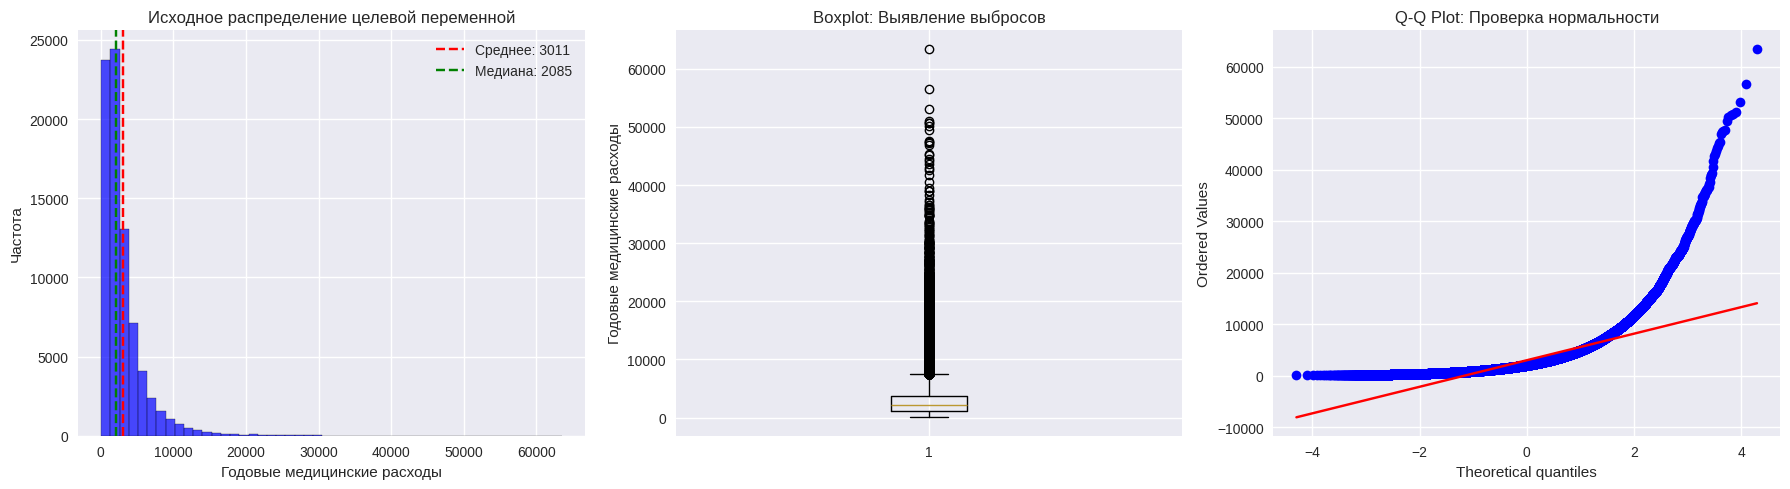

Статистики распределения целевой переменной:
  Среднее: 3011.13
  Медиана: 2084.55
  Стандартное отклонение: 3114.07
  Асимметрия: 3.83
  Эксцесс: 27.76
  Минимум: 55.55
  Максимум: 63482.48
  95-й перцентиль: 8583.84
Диагностика:
Сильная асимметрия: распределение сильно скошено
Высокий эксцесс: распределение имеет тяжелые хвосты
Сильные выбросы: есть экстремально высокие значения


In [47]:
fig, axes = plt.subplots(1, 3, figsize = (18, 5))

axes[0].hist(y_train_final, bins = 50, alpha = 0.7,
             color = "blue", edgecolor = "black")
axes[0].set_xlabel("Годовые медицинские расходы")
axes[0].set_ylabel("Частота")
axes[0].set_title("Исходное распределение целевой переменной")
axes[0].axvline(y_train_final.mean(), color = "red", linestyle = "--",
                label = f"Среднее: {y_train_final.mean():.0f}")
axes[0].axvline(y_train_final.median(), color = "green", linestyle = "--",
                label = f"Медиана: {y_train_final.median():.0f}")
axes[0].legend()

axes[1].boxplot(y_train_final)
axes[1].set_ylabel("Годовые медицинские расходы")
axes[1].set_title("Boxplot: Выявление выбросов")

stats.probplot(y_train_final, dist = "norm", plot = axes[2])
axes[2].set_title("Q-Q Plot: Проверка нормальности")

plt.tight_layout()
plt.show()

print("Статистики распределения целевой переменной:")
stats_dict = {
  "Среднее": y_train_final.mean(),
  "Медиана": y_train_final.median(),
  "Стандартное отклонение": y_train_final.std(),
  "Асимметрия": y_train_final.skew(),
  "Эксцесс": y_train_final.kurtosis(),
  "Минимум": y_train_final.min(),
  "Максимум": y_train_final.max(),
  "95-й перцентиль": y_train_final.quantile(0.95)
}

for stat, value in stats_dict.items():
  print(f"  {stat}: {value:.2f}")

print(f"Диагностика:")
if abs(stats_dict["Асимметрия"]) > 1:
  print("Сильная асимметрия: распределение сильно скошено")
if stats_dict["Эксцесс"] > 3:
  print("Высокий эксцесс: распределение имеет тяжелые хвосты")
if stats_dict["Максимум"] > stats_dict["95-й перцентиль"] * 3:
  print("Сильные выбросы: есть экстремально высокие значения")

# Методы борьбы с асимметрией

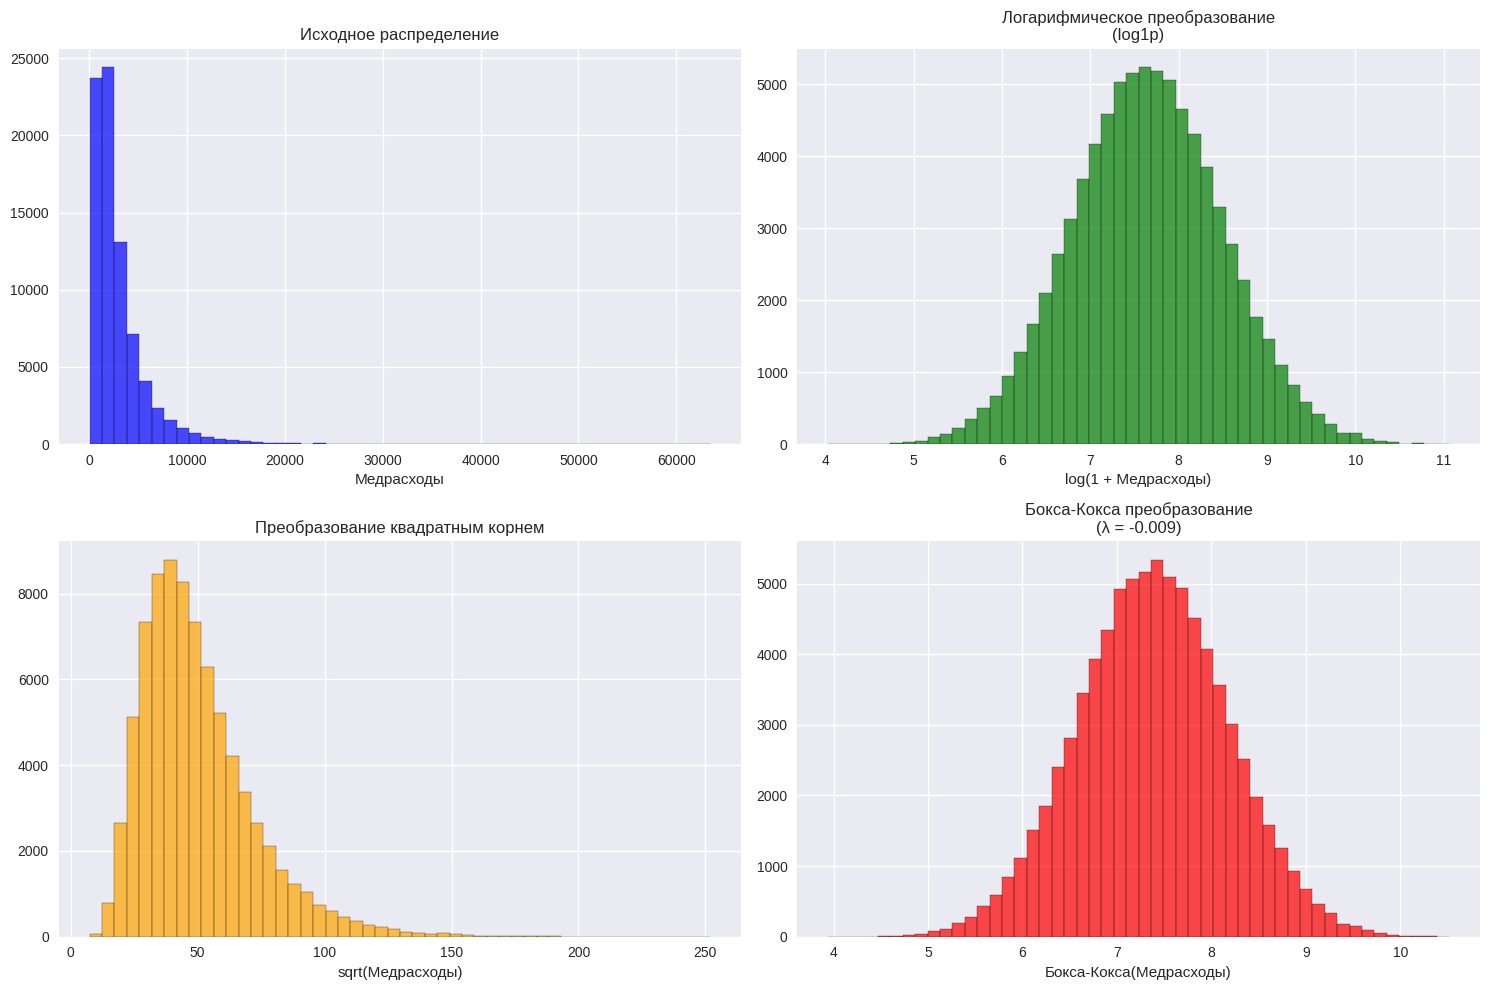

Сравнение статистик после преобразований:


,Исходные,Логарифм,Квадратный корень,Бокса-Кокса
Асимметрия,3.8281,0.0250,1.4295,0.0000
Эксцесс,27.7587,-0.0197,3.6085,-0.0189


In [48]:
y_train_log = np.log1p(y_train_final)
y_train_sqrt = np.sqrt(y_train_final)
y_train_boxcox, lmbda = stats.boxcox(y_train_final)

fig, axes = plt.subplots(2, 2, figsize = (15, 10))

axes[0, 0].hist(y_train_final, bins = 50, alpha = 0.7,
                color = "blue", edgecolor = "black")
axes[0, 0].set_title("Исходное распределение")
axes[0, 0].set_xlabel("Медрасходы")

axes[0, 1].hist(y_train_log, bins = 50, alpha = 0.7,
                color = "green", edgecolor = "black")
axes[0, 1].set_title(f"Логарифмическое преобразование\n(log1p)")
axes[0, 1].set_xlabel("log(1 + Медрасходы)")

axes[1, 0].hist(y_train_sqrt, bins = 50, alpha = 0.7,
                color = "orange", edgecolor = "black")
axes[1, 0].set_title("Преобразование квадратным корнем")
axes[1, 0].set_xlabel("sqrt(Медрасходы)")

axes[1, 1].hist(y_train_boxcox, bins = 50, alpha = 0.7,
                color = "red", edgecolor = "black")
axes[1, 1].set_title(f"Бокса-Кокса преобразование\n(λ = {lmbda:.3f})")
axes[1, 1].set_xlabel("Бокса-Кокса(Медрасходы)")

plt.tight_layout()
plt.show()

transform_stats = pd.DataFrame({
  "Исходные": [y_train_final.skew(), y_train_final.kurtosis()],
  "Логарифм": [y_train_log.skew(), y_train_log.kurtosis()],
  "Квадратный корень": [y_train_sqrt.skew(), y_train_sqrt.kurtosis()],
  "Бокса-Кокса": [stats.skew(y_train_boxcox), stats.kurtosis(y_train_boxcox)]
}, index=["Асимметрия", "Эксцесс"])

print("Сравнение статистик после преобразований:")
display(transform_stats.round(4))

# Обучение моделей на преобразованных данных

In [49]:
def train_and_evaluate_with_transform(y_train_transformed, y_test,
                                      transform_name, inverse_transform_func):
  print(f"\nОбучение с {transform_name} преобразованием...")

  model = lgb.LGBMRegressor(
    n_estimators = 200,
    learning_rate = 0.05,
    num_leaves = 31,
    random_state = 42,
    verbose = -1
  )

  model.fit(X_train_final, y_train_transformed)

  y_pred_transformed = model.predict(X_test_final)
  y_pred_original = inverse_transform_func(y_pred_transformed)

  mae = mean_absolute_error(y_test, y_pred_original)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred_original))
  r2 = r2_score(y_test, y_pred_original)

  print(f"   MAE: {mae:.2f}")
  print(f"   RMSE: {rmse:.2f}")
  print(f"   R²: {r2:.4f}")

  return model, y_pred_original, {"MAE": mae, "RMSE": rmse, "R²": r2}

def inverse_log(x):
  return np.expm1(x)

def inverse_sqrt(x):
  return x ** 2

def inverse_boxcox(x, lmbda = lmbda):
  if lmbda == 0:
    return np.exp(x)
  else:
    return (x * lmbda + 1) ** (1 / lmbda)

results_transformed = {}

print("Базовая модель (без преобразования):")
base_model = lgb.LGBMRegressor(
  n_estimators = 200,
  learning_rate = 0.05,
  num_leaves = 31,
  random_state = 42,
  verbose = -1
)
base_model.fit(X_train_final, y_train_final)
y_pred_base = base_model.predict(X_test_final)
mae_base = mean_absolute_error(y_test_final, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test_final, y_pred_base))
r2_base = r2_score(y_test_final, y_pred_base)

print(f"   MAE: {mae_base:.2f}")
print(f"   RMSE: {rmse_base:.2f}")
print(f"   R²: {r2_base:.4f}")

results_transformed["Базовый"] = {
  "model": base_model,
  "predictions": y_pred_base,
  "metrics": {"MAE": mae_base, "RMSE": rmse_base, "R²": r2_base}
}

model_log, pred_log, metrics_log = train_and_evaluate_with_transform(
    y_train_log, y_test_final, "логарифмическим", inverse_log)
results_transformed["Логарифмический"] = {
  "model": model_log,
  "predictions": pred_log,
  "metrics": metrics_log
}

model_sqrt, pred_sqrt, metrics_sqrt = train_and_evaluate_with_transform(
    y_train_sqrt, y_test_final, "квадратным корнем", inverse_sqrt)
results_transformed["Квадратный корень"] = {
  "model": model_sqrt,
  "predictions": pred_sqrt,
  "metrics": metrics_sqrt
}

model_boxcox, pred_boxcox, metrics_boxcox = train_and_evaluate_with_transform(
    y_train_boxcox, y_test_final, "Бокса-Кокса",
    lambda x: inverse_boxcox(x, lmbda))
results_transformed["Бокса-Кокса"] = {
  "model": model_boxcox,
  "predictions": pred_boxcox,
  "metrics": metrics_boxcox
}

Базовая модель (без преобразования):
   MAE: 52.51
   RMSE: 688.68
   R²: 0.9531

Обучение с логарифмическим преобразованием...
   MAE: 48.40
   RMSE: 665.31
   R²: 0.9562

Обучение с квадратным корнем преобразованием...
   MAE: 48.57
   RMSE: 667.93
   R²: 0.9559

Обучение с Бокса-Кокса преобразованием...
   MAE: 48.85
   RMSE: 664.35
   R²: 0.9564


# Сравнение результатов различных преобразований

Сравнение методов борьбы с асимметрией:


,Метод,MAE,RMSE,R²
1,Логарифмический,48.3955,665.3145,0.9562
2,Квадратный корень,48.5659,667.9253,0.9559
3,Бокса-Кокса,48.8488,664.3501,0.9564
0,Базовый,52.5064,688.6781,0.9531


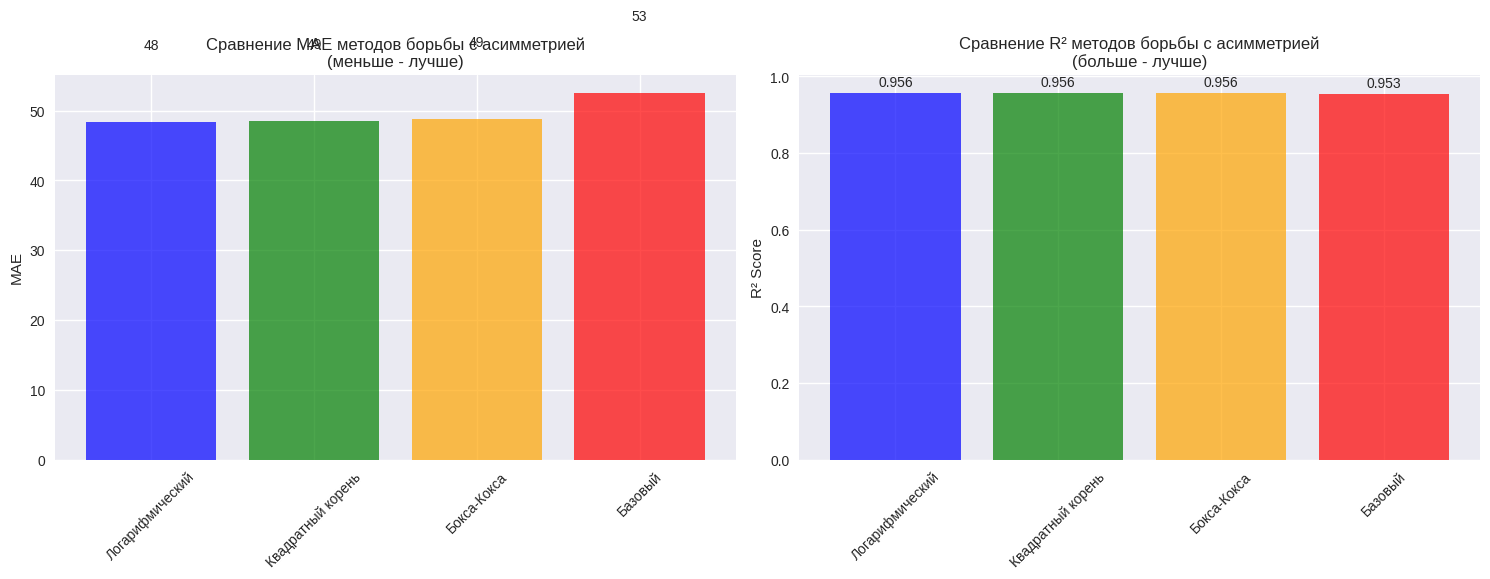


 Лучший метод: Логарифмический
   Улучшение MAE: 7.83%
   MAE: 48.40 (было 52.51)


In [50]:
comparison_data = []
for method, results in results_transformed.items():
  metrics = results["metrics"]
  comparison_data.append({
    "Метод": method,
    "MAE": metrics["MAE"],
    "RMSE": metrics["RMSE"],
    "R²": metrics["R²"]
  })

comparison_df = pd.DataFrame(comparison_data).sort_values("MAE")
print("Сравнение методов борьбы с асимметрией:")
display(comparison_df.round(4))

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

methods = comparison_df["Метод"]
mae_values = comparison_df["MAE"]

bars = axes[0].bar(methods, mae_values,
                   color = ["blue", "green", "orange", "red"], alpha = 0.7)
axes[0].set_ylabel("MAE")
axes[0].set_title("Сравнение MAE методов борьбы с асимметрией\n(меньше - лучше)")
axes[0].tick_params(axis = 'x', rotation = 45)

for bar in bars:
  height = bar.get_height()
  axes[0].text(bar.get_x() + bar.get_width() / 2, height + 10,
               f"{height:.0f}", ha = "center", va = "bottom")

r2_values = comparison_df["R²"]

bars = axes[1].bar(methods, r2_values,
                   color = ["blue", "green", "orange", "red"], alpha = 0.7)
axes[1].set_ylabel("R² Score")
axes[1].set_title("Сравнение R² методов борьбы с асимметрией\n(больше - лучше)")
axes[1].tick_params(axis = 'x', rotation = 45)

for bar in bars:
  height = bar.get_height()
  axes[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01,
              f"{height:.3f}", ha = "center", va = "bottom")

plt.tight_layout()
plt.show()

best_method = comparison_df.iloc[0]
base_mae = comparison_df[comparison_df["Метод"] == "Базовый"]["MAE"].values[0]
improvement = ((base_mae - best_method["MAE"]) / base_mae) * 100

print(f"\n Лучший метод: {best_method["Метод"]}")
print(f"   Улучшение MAE: {improvement:.2f}%")
print(f"   MAE: {best_method["MAE"]:.2f} (было {base_mae:.2f})")

# Обрезка выбросов

In [51]:
def trim_outliers(y, lower_quantile = 0.05, upper_quantile = 0.95):
  lower_bound = y.quantile(lower_quantile)
  upper_bound = y.quantile(upper_quantile)
  y_trimmed = y.clip(lower = lower_bound, upper = upper_bound)
  return y_trimmed

y_train_trimmed = trim_outliers(y_train_final)

print("Статистики до и после обрезки выбросов:")
trim_stats = pd.DataFrame({
  "До обрезки": [y_train_final.min(), y_train_final.max(),
                 y_train_final.mean(), y_train_final.skew()],
  "После обрезки": [y_train_trimmed.min(), y_train_trimmed.max(),
                    y_train_trimmed.mean(), y_train_trimmed.skew()]
}, index=["Минимум", "Максимум", "Среднее", "Асимметрия"])

display(trim_stats.round(2))

print("\n Обучение на обрезанных данных...")
model_trimmed = lgb.LGBMRegressor(
  n_estimators = 200,
  learning_rate = 0.05,
  num_leaves = 31,
  random_state = 42,
  verbose = -1
)

model_trimmed.fit(X_train_final, y_train_trimmed)
y_pred_trimmed = model_trimmed.predict(X_test_final)

y_pred_trimmed_clipped = np.clip(y_pred_trimmed, y_train_trimmed.min(),
                                 y_train_trimmed.max())

mae_trimmed = mean_absolute_error(y_test_final, y_pred_trimmed_clipped)
rmse_trimmed = np.sqrt(mean_squared_error(y_test_final, y_pred_trimmed_clipped))
r2_trimmed = r2_score(y_test_final, y_pred_trimmed_clipped)

print(f"   MAE: {mae_trimmed:.2f}")
print(f"   RMSE: {rmse_trimmed:.2f}")
print(f"   R²: {r2_trimmed:.4f}")

comparison_data.append({
  "Метод": "Обрезка выбросов",
  "MAE": mae_trimmed,
  "RMSE": rmse_trimmed,
  "R²": r2_trimmed
})

final_comparison = pd.DataFrame(comparison_data).sort_values("MAE")
print("\nФинальное сравнение всех методов:")
display(final_comparison.round(4))

Статистики до и после обрезки выбросов:


,До обрезки,После обрезки
Минимум,55.55,516.29
Максимум,63482.48,8583.84
Среднее,3011.13,2797.98
Асимметрия,3.83,1.28



 Обучение на обрезанных данных...
   MAE: 238.34
   RMSE: 1686.97
   R²: 0.7187

Финальное сравнение всех методов:


,Метод,MAE,RMSE,R²
1,Логарифмический,48.3955,665.3145,0.9562
2,Квадратный корень,48.5659,667.9253,0.9559
3,Бокса-Кокса,48.8488,664.3501,0.9564
0,Базовый,52.5064,688.6781,0.9531
4,Обрезка выбросов,238.3433,1686.9657,0.7187


# Комбинированный подход

Лучший метод: Логарифмический


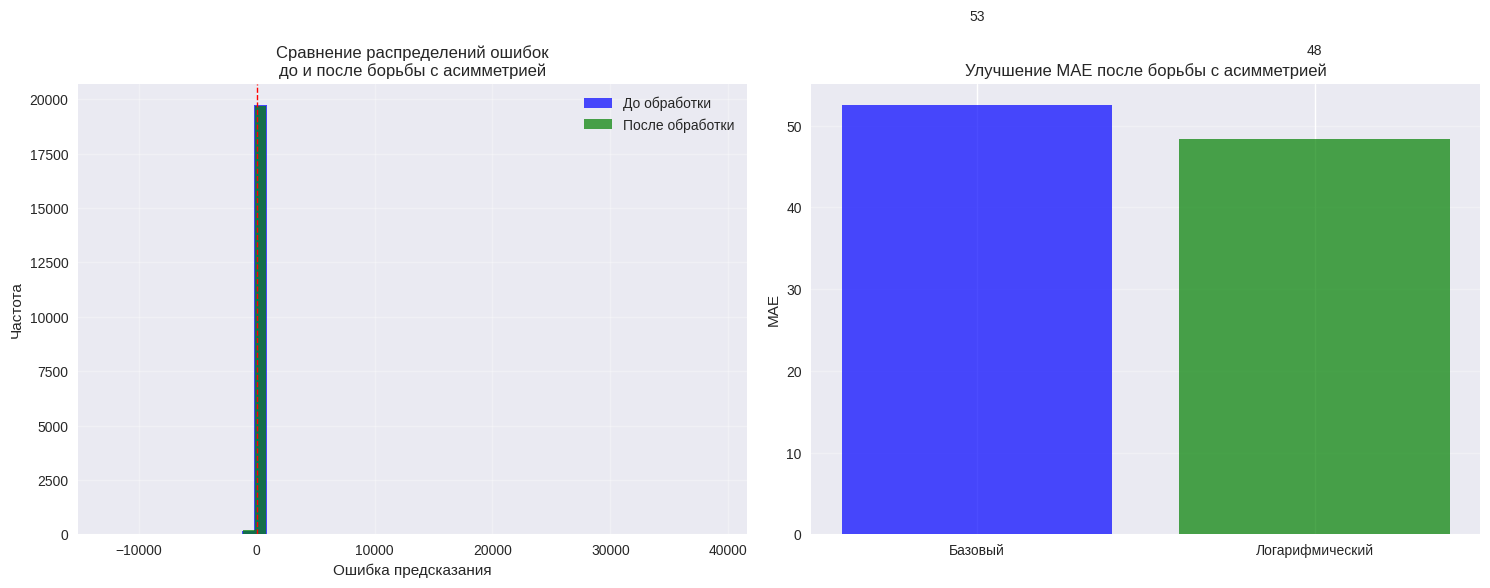


 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ БОРЬБЫ С АСИММЕТРИЕЙ:
 Лучший метод: Логарифмический
 Улучшение MAE: 7.83%
 Итоговый MAE: 48.40
 Итоговый R²: 0.9562


In [52]:
best_transform_method = final_comparison.iloc[0]["Метод"]
print(f"Лучший метод: {best_transform_method}")

fig, axes = plt.subplots(1, 2, figsize = (15, 6))

best_predictions = results_transformed.get(best_transform_method, {}).get("predictions", y_pred_base)
if best_transform_method == "Обрезка выбросов":
  best_predictions = y_pred_trimmed_clipped

errors_before = y_test_final - y_pred_base
errors_after = y_test_final - best_predictions

axes[0].hist(errors_before, bins = 50, alpha = 0.7,
             label = "До обработки", color = "blue")
axes[0].hist(errors_after, bins = 50, alpha = 0.7,
             label = "После обработки", color = "green")
axes[0].axvline(x = 0, color = "red", linestyle = "--", linewidth = 1)
axes[0].set_xlabel("Ошибка предсказания")
axes[0].set_ylabel("Частота")
axes[0].set_title("Сравнение распределений ошибок\nдо и после борьбы с асимметрией")
axes[0].legend()
axes[0].grid(alpha = 0.3)

methods_comparison = ["Базовый", best_transform_method]
mae_comparison = [mae_base, final_comparison.iloc[0]["MAE"]]

bars = axes[1].bar(methods_comparison, mae_comparison,
                   color = ["blue", "green"], alpha = 0.7)
axes[1].set_ylabel("MAE")
axes[1].set_title("Улучшение MAE после борьбы с асимметрией")
axes[1].grid(axis = 'y', alpha = 0.3)

for bar in bars:
  height = bar.get_height()
  axes[1].text(bar.get_x() + bar.get_width() / 2, height + 10,
              f"{height:.0f}", ha = "center", va = "bottom")

plt.tight_layout()
plt.show()

final_improvement = ((mae_base - final_comparison.iloc[0]["MAE"]) / mae_base) * 100

print("\n ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ БОРЬБЫ С АСИММЕТРИЕЙ:")
print(f" Лучший метод: {best_transform_method}")
print(f" Улучшение MAE: {final_improvement:.2f}%")
print(f" Итоговый MAE: {final_comparison.iloc[0]["MAE"]:.2f}")
print(f" Итоговый R²: {final_comparison.iloc[0]["R²"]:.4f}")

# **Исключение коррелированных переменных**
Цель: снизить избыточность информации в данных, ускорить обучение и повысить устойчивость к шуму
# Анализ текущей корреляционной матрицы

Размер корреляционной матрицы: (83, 83)


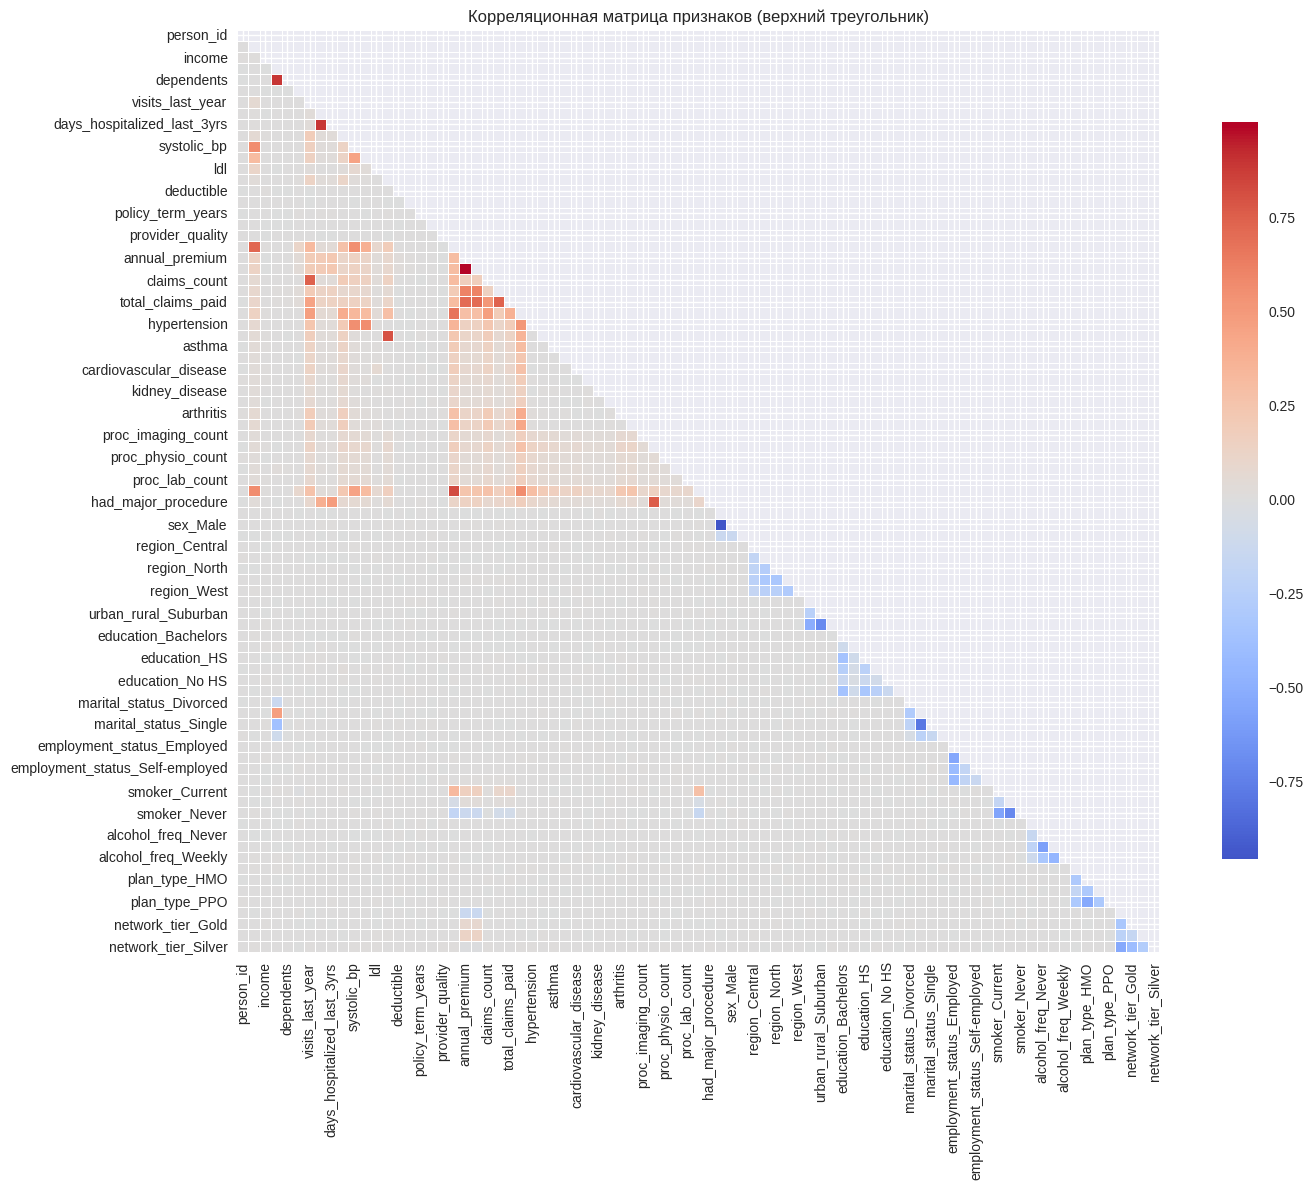

Анализ высоких корреляций:
Найдено пар с корреляцией > 0.8: 5


,Feature1,Feature2,Correlation
3,annual_premium,monthly_premium,1.000000
0,household_size,dependents,0.886291
1,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,0.885645
2,risk_score,is_high_risk,0.821208
4,sex_Female,sex_Male,-0.960591


In [53]:
numeric_columns = X_train_final.select_dtypes(include = [np.number]).columns
correlation_matrix = X_train_final[numeric_columns].corr()

print(f"Размер корреляционной матрицы: {correlation_matrix.shape}")

plt.figure(figsize = (15, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
sns.heatmap(correlation_matrix, mask = mask, cmap = "coolwarm", center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": .8})
plt.title("Корреляционная матрица признаков (верхний треугольник)")
plt.tight_layout()
plt.show()

print("Анализ высоких корреляций:")
correlation_threshold = 0.8

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
  for j in range(i+1, len(correlation_matrix.columns)):
    if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
      high_corr_pairs.append({
        "Feature1": correlation_matrix.columns[i],
        "Feature2": correlation_matrix.columns[j],
        "Correlation": correlation_matrix.iloc[i, j]
      })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values("Correlation",
                                                         ascending = False)

if len(high_corr_df) > 0:
  print(f"Найдено пар с корреляцией > {correlation_threshold}: {len(high_corr_df)}")
  display(high_corr_df.head(10))
else:
  print(f"Пар с корреляцией > {correlation_threshold} не найдено")

# Автоматическое обнаружение коррелированных признаков

In [54]:
def find_correlated_features(corr_matrix, threshold=0.8):
  corr_matrix_abs = corr_matrix.abs()

  upper_triangle = corr_matrix_abs.where(
      np.triu(np.ones_like(corr_matrix_abs, dtype = bool), k = 1))

  high_corr_pairs = []
  for col in upper_triangle.columns:
    for idx in upper_triangle.index:
      if not np.isnan(upper_triangle.loc[idx, col]) and upper_triangle.loc[idx, col] > threshold:
        high_corr_pairs.append((idx, col, upper_triangle.loc[idx, col]))

  correlated_groups = []
  used_features = set()

  for feat1, feat2, corr in high_corr_pairs:
    if feat1 not in used_features and feat2 not in used_features:
      group = {feat1, feat2}
      correlated_groups.append(group)
      used_features.update(group)
    elif feat1 in used_features and feat2 not in used_features:
      for group in correlated_groups:
        if feat1 in group:
          group.add(feat2)
          used_features.add(feat2)
          break
    elif feat2 in used_features and feat1 not in used_features:
      for group in correlated_groups:
        if feat2 in group:
          group.add(feat1)
          used_features.add(feat1)
          break

  return correlated_groups, high_corr_pairs

thresholds = [0.9, 0.8, 0.7]
correlation_analysis = {}

for threshold in thresholds:
  groups, pairs = find_correlated_features(correlation_matrix, threshold)
  correlation_analysis[threshold] = {
    "groups": groups,
    "pairs_count": len(pairs),
    "features_involved": len(set([f for pair in pairs for f in pair[:2]]))
  }

  print(f"\n Порог корреляции: {threshold}")
  print(f"   Количество пар: {len(pairs)}")
  print(f"   Уникальных признаков в парах: {correlation_analysis[threshold]["features_involved"]}")
  print(f"   Групп коррелированных признаков: {len(groups)}")

  if groups:
    for i, group in enumerate(groups[:3]):
      print(f"   Группа {i+1}: {group}")

optimal_threshold = 0.8
print(f"\n Выбранный порог корреляции: {optimal_threshold}")


 Порог корреляции: 0.9
   Количество пар: 2
   Уникальных признаков в парах: 4
   Групп коррелированных признаков: 2
   Группа 1: {'annual_premium', 'monthly_premium'}
   Группа 2: {'sex_Female', 'sex_Male'}

 Порог корреляции: 0.8
   Количество пар: 5
   Уникальных признаков в парах: 10
   Групп коррелированных признаков: 5
   Группа 1: {'household_size', 'dependents'}
   Группа 2: {'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs'}
   Группа 3: {'annual_premium', 'monthly_premium'}

 Порог корреляции: 0.7
   Количество пар: 15
   Уникальных признаков в парах: 25
   Групп коррелированных признаков: 11
   Группа 1: {'household_size', 'dependents'}
   Группа 2: {'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs'}
   Группа 3: {'is_high_risk', 'age', 'risk_score'}

 Выбранный порог корреляции: 0.8


# Стратегия исключения коррелированных признаков

In [55]:
def select_features_to_remove(correlated_groups, X, y, model = None):
  features_to_remove = []

  for group in correlated_groups:
    group_list = list(group)

    if len(group_list) == 1:
      continue

    print(f"\nАнализ группы: {group_list}")

    corr_with_target = []
    for feature in group_list:
      if feature in X.columns:
        corr = np.corrcoef(X[feature], y)[0, 1]
        corr_with_target.append((feature, abs(corr)))

    if corr_with_target:
      corr_with_target.sort(key = lambda x: x[1], reverse = True)
      best_feature = corr_with_target[0][0]
      features_to_remove.extend([f for f in group_list if f != best_feature])
      print(f"  Оставляем: {best_feature} (корр. с целью: {corr_with_target[0][1]:.3f})")
      print(f"  Удаляем: {[f for f in group_list if f != best_feature]}")

  return features_to_remove

correlated_groups, _ = find_correlated_features(correlation_matrix, optimal_threshold)
features_to_remove = select_features_to_remove(correlated_groups, X_train_final, y_train_final)

print(f"\n Итоговый список признаков для удаления:")
print(f"Количество признаков для удаления: {len(features_to_remove)}")
if features_to_remove:
  for feature in features_to_remove:
    print(f"  - {feature}")
else:
  print("  Нет признаков для удаления")


Анализ группы: ['household_size', 'dependents']
  Оставляем: dependents (корр. с целью: 0.004)
  Удаляем: ['household_size']

Анализ группы: ['hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs']
  Оставляем: days_hospitalized_last_3yrs (корр. с целью: 0.228)
  Удаляем: ['hospitalizations_last_3yrs']

Анализ группы: ['annual_premium', 'monthly_premium']
  Оставляем: monthly_premium (корр. с целью: 0.965)
  Удаляем: ['annual_premium']

Анализ группы: ['is_high_risk', 'risk_score']
  Оставляем: risk_score (корр. с целью: 0.307)
  Удаляем: ['is_high_risk']

Анализ группы: ['sex_Female', 'sex_Male']
  Оставляем: sex_Male (корр. с целью: 0.008)
  Удаляем: ['sex_Female']

 Итоговый список признаков для удаления:
Количество признаков для удаления: 5
  - household_size
  - hospitalizations_last_3yrs
  - annual_premium
  - is_high_risk
  - sex_Female


# Применение фильтрации и создание нового набора данных

Сравнение размерностей до и после фильтрации:
Обучающая выборка: 83 - 78 признаков
Тестовая выборка:  83 - 78 признаков
Удалено признаков: 5

Оставшиеся признаки (78):
Распределение признаков по категориям:
  Прочие: 41 признаков
  Демография: 8 признаков
  Социально-экономические: 11 признаков
  Биометрия: 5 признаков
  Мед. история: 3 признаков
  Заболевания: 3 признаков
  Образ жизни: 7 признаков


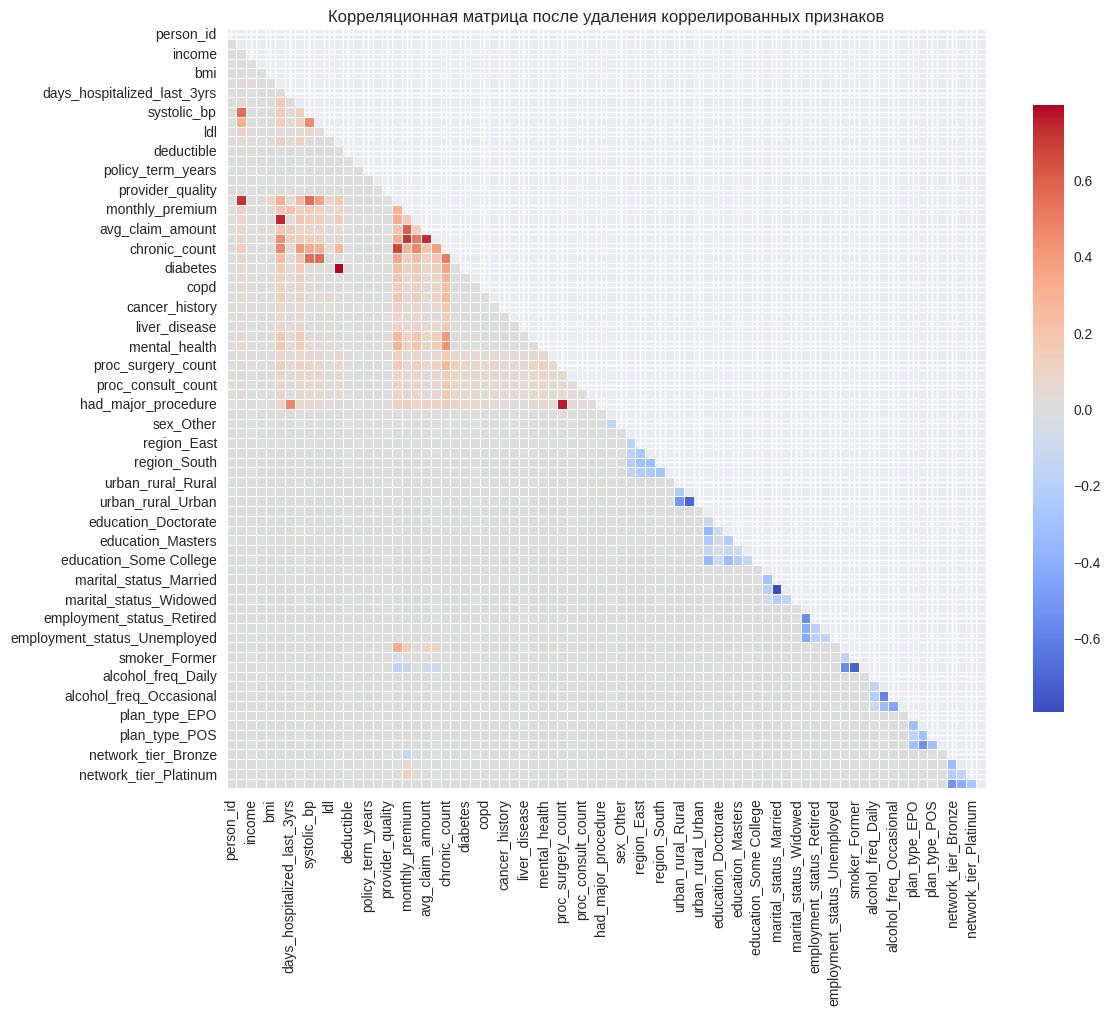

In [56]:
X_train_filtered = X_train_final.drop(columns = features_to_remove,
                                      errors = "ignore")
X_test_filtered = X_test_final.drop(columns = features_to_remove,
                                    errors = "ignore")

print("Сравнение размерностей до и после фильтрации:")
print(f"Обучающая выборка: {X_train_final.shape[1]} - {X_train_filtered.shape[1]} признаков")
print(f"Тестовая выборка:  {X_test_final.shape[1]} - {X_test_filtered.shape[1]} признаков")
print(f"Удалено признаков: {X_train_final.shape[1] - X_train_filtered.shape[1]}")

remaining_features = X_train_filtered.columns.tolist()
print(f"\nОставшиеся признаки ({len(remaining_features)}):")
feature_categories = {}
for feature in remaining_features:
  category = "Прочие"
  if any(x in feature for x in ["age", "sex", "region"]):
    category = "Демография"
  elif any(x in feature for x in ["bmi", "bp", "ldl", "hba1c"]):
    category = "Биометрия"
  elif any(x in feature for x in ["income", "education", "employment"]):
    category = "Социально-экономические"
  elif any(x in feature for x in ["chronic", "hypertension", "diabetes"]):
    category = "Заболевания"
  elif any(x in feature for x in ["smoker", "alcohol"]):
    category = "Образ жизни"
  elif any(x in feature for x in ["visits", "hospital", "medication"]):
    category = "Мед. история"

  if category not in feature_categories:
    feature_categories[category] = []
  feature_categories[category].append(feature)

print("Распределение признаков по категориям:")
for category, features in feature_categories.items():
  print(f"  {category}: {len(features)} признаков")

plt.figure(figsize = (12, 10))
correlation_matrix_filtered = X_train_filtered.corr()
mask_filtered = np.triu(np.ones_like(correlation_matrix_filtered, dtype = bool))
sns.heatmap(correlation_matrix_filtered, mask = mask_filtered,
            cmap = "coolwarm", center = 0, square = True, linewidths = 0.5,
            cbar_kws = {"shrink": .8})
plt.title("Корреляционная матрица после удаления коррелированных признаков")
plt.tight_layout()
plt.show()

# Оценка влияния на качество модели

Обучение модели на отфильтрованных данных...

Сравнение качества модели:


,Метрика,До фильтрации,После фильтрации,Разница
0,MAE,52.5064,54.1932,1.6868
1,RMSE,688.6781,689.2653,0.5873
2,R²,0.9531,0.9530,-0.0001
3,Время обучения (с),171.4781,4.9519,-166.5262
4,Кол-во признаков,83.0000,78.0000,-5.0000


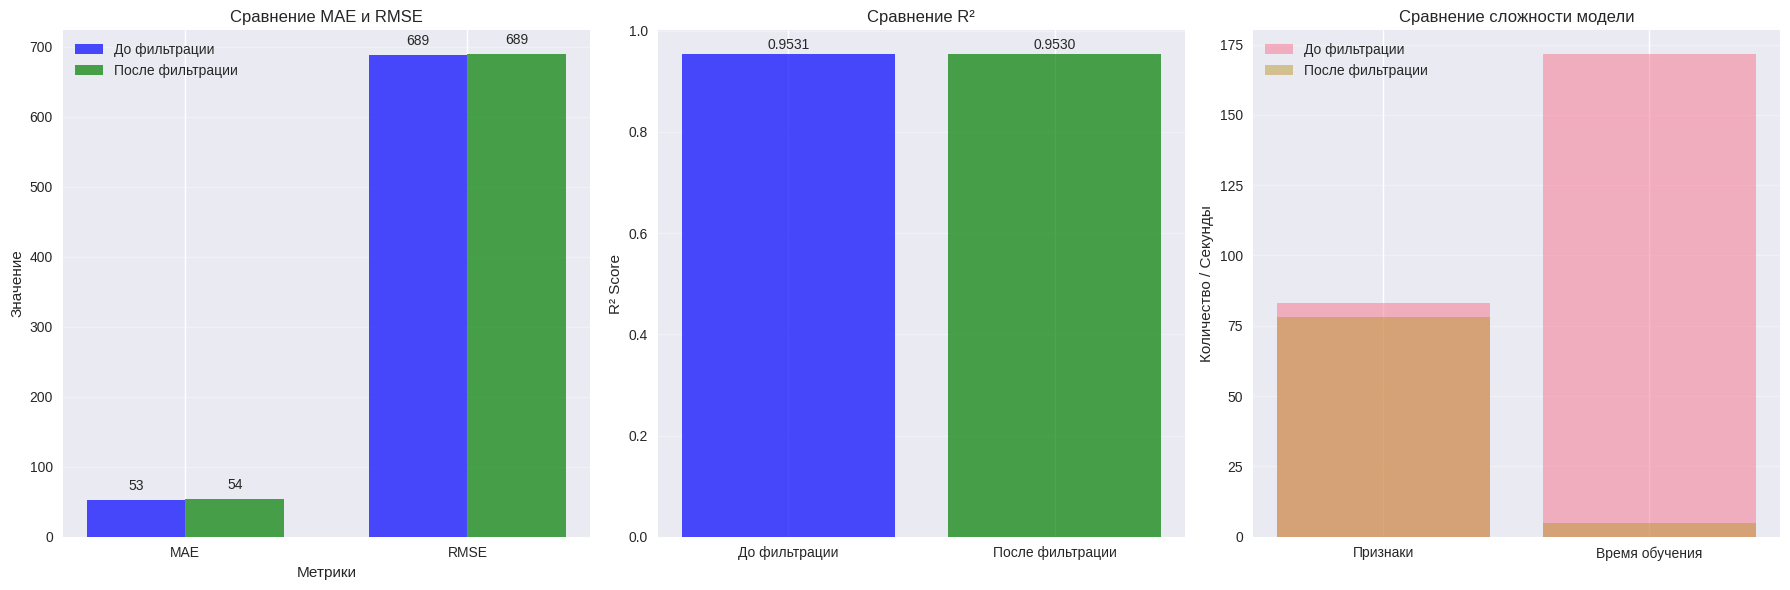

In [57]:
print("Обучение модели на отфильтрованных данных...")

model_filtered = lgb.LGBMRegressor(
  n_estimators = 200,
  learning_rate = 0.05,
  num_leaves = 31,
  random_state = 42,
  verbose = -1
)

start_time = time.time()
model_filtered.fit(X_train_filtered, y_train_final)
training_time_filtered = time.time() - start_time

y_pred_filtered = model_filtered.predict(X_test_filtered)

mae_filtered = mean_absolute_error(y_test_final, y_pred_filtered)
rmse_filtered = np.sqrt(mean_squared_error(y_test_final, y_pred_filtered))
r2_filtered = r2_score(y_test_final, y_pred_filtered)

print("\nСравнение качества модели:")
comparison_metrics = pd.DataFrame({
  "Метрика": ["MAE", "RMSE", "R²", "Время обучения (с)", "Кол-во признаков"],
  "До фильтрации": [mae_base, rmse_base, r2_base, search_time,
                    X_train_final.shape[1]],
  "После фильтрации": [mae_filtered, rmse_filtered, r2_filtered,
                       training_time_filtered, X_train_filtered.shape[1]],
  "Разница": [mae_filtered - mae_base, rmse_filtered - rmse_base,
              r2_filtered - r2_base, training_time_filtered - search_time,
              X_train_filtered.shape[1] - X_train_final.shape[1]]
})

display(comparison_metrics.round(4))

fig, axes = plt.subplots(1, 3, figsize = (18, 6))

metrics_names = ["MAE", "RMSE"]
before_metrics = [mae_base, rmse_base]
after_metrics = [mae_filtered, rmse_filtered]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = axes[0].bar(x - width / 2, before_metrics, width,
                    label = "До фильтрации", alpha = 0.7, color = "blue")
bars2 = axes[0].bar(x + width / 2, after_metrics, width,
                    label = "После фильтрации", alpha = 0.7, color = "green")

axes[0].set_xlabel("Метрики")
axes[0].set_ylabel("Значение")
axes[0].set_title("Сравнение MAE и RMSE")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_names)
axes[0].legend()
axes[0].grid(axis='y', alpha = 0.3)

for bars in [bars1, bars2]:
  for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height + 10,
               f"{height:.0f}", ha = "center", va = "bottom")

axes[1].bar(["До фильтрации", "После фильтрации"], [r2_base, r2_filtered],
           color = ["blue", "green"], alpha = 0.7)
axes[1].set_ylabel("R² Score")
axes[1].set_title("Сравнение R²")
axes[1].grid(axis = 'y', alpha = 0.3)

for i, value in enumerate([r2_base, r2_filtered]):
  axes[1].text(i, value + 0.01, f"{value:.4f}", ha = "center")

axes[2].bar(["Признаки", "Время обучения"],
           [X_train_final.shape[1], search_time],
           alpha = 0.5, label = "До фильтрации")
axes[2].bar(["Признаки", "Время обучения"],
           [X_train_filtered.shape[1], training_time_filtered],
           alpha = 0.5, label = "После фильтрации")
axes[2].set_ylabel("Количество / Секунды")
axes[2].set_title("Сравнение сложности модели")
axes[2].legend()
axes[2].grid(axis = 'y', alpha = 0.3)

plt.tight_layout()
plt.show()

# Анализ важности признаков до и после

15 важных признаков до фильтрации:


,feature,importance_before
21,monthly_premium,517
20,annual_premium,467
79,network_tier_Bronze,416
81,network_tier_Platinum,264
82,network_tier_Silver,230
14,deductible,200
80,network_tier_Gold,102
22,claims_count,68
10,systolic_bp,63
23,avg_claim_amount,61



15 важных признаков после фильтрации:


,feature,importance_after
18,monthly_premium,1529
74,network_tier_Bronze,477
12,deductible,357
76,network_tier_Platinum,296
77,network_tier_Silver,271
11,hba1c,221
20,avg_claim_amount,185
21,total_claims_paid,182
2,income,174
8,systolic_bp,172



 Анализ изменений в признаках:
 Общие признаки: 12
 Новые признаки: 3
  ['person_id', 'age', 'bmi']
 Выбывшие: 3
  ['annual_premium', 'provider_quality', 'network_tier_Gold']


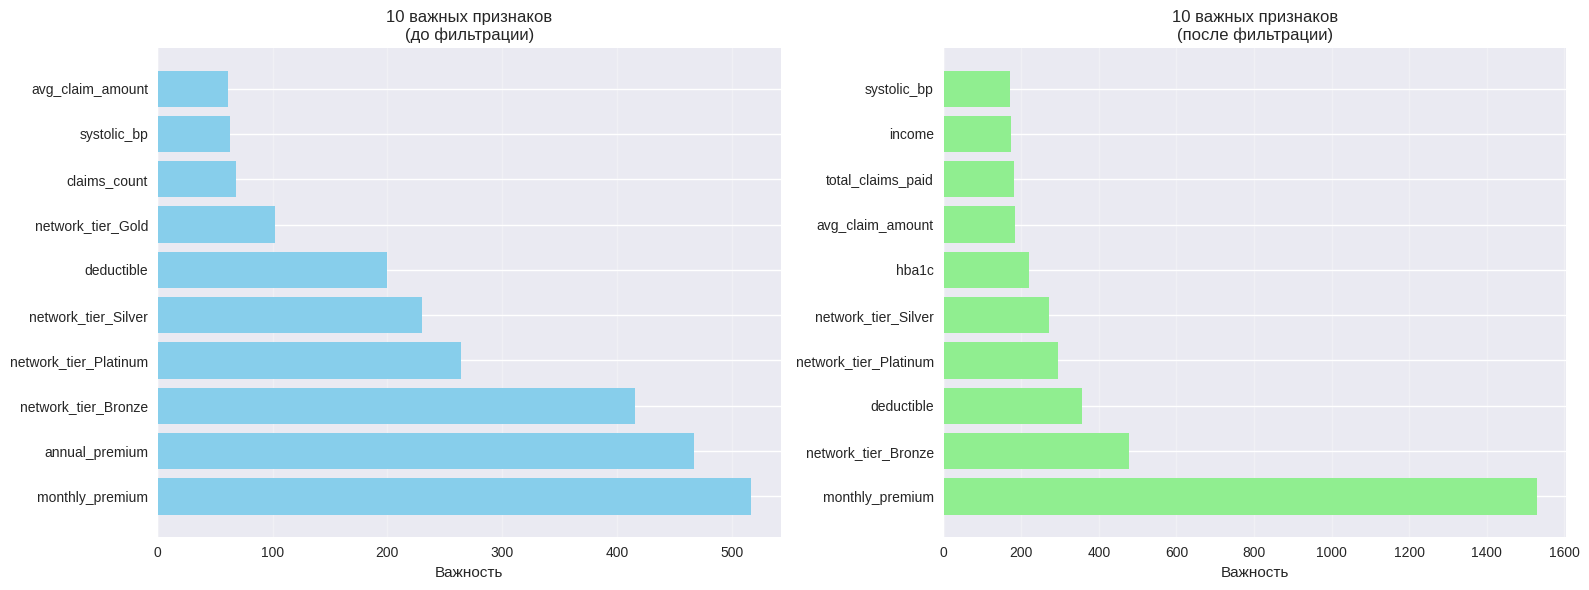


 Статистика стабильности важности признаков:
 Стабильность 10 признаков: 70.0%
 Общих признаков в 10: 7

Изменение позиций общих признаков в 10:


,feature,position_before,position_after,change
5,network_tier_Bronze,80,75,-5
6,network_tier_Silver,83,78,-5
4,network_tier_Platinum,82,77,-5
0,monthly_premium,22,19,-3
1,avg_claim_amount,24,21,-3
2,systolic_bp,11,9,-2
3,deductible,15,13,-2


 Улучшили позицию: 7 признаков
 Ухудшили позицию: 0 признаков
 Не изменили позицию: 0 признаков


In [58]:
feature_importance_before = pd.DataFrame({
  "feature": model.feature_name(),
  "importance_before": model.feature_importance()
}).sort_values("importance_before", ascending = False)

feature_importance_after = pd.DataFrame({
  "feature": model_filtered.feature_name_,
  "importance_after": model_filtered.feature_importances_
}).sort_values("importance_after", ascending = False)

importance_comparison = pd.merge(
  feature_importance_before,
  feature_importance_after,
  on = "feature",
  how = "outer"
).fillna(0)

top_features_before = feature_importance_before.head(15)
top_features_after = feature_importance_after.head(15)

print("15 важных признаков до фильтрации:")
display(top_features_before)

print("\n15 важных признаков после фильтрации:")
display(top_features_after)

common_top_features = set(top_features_before["feature"]).intersection(set(top_features_after["feature"]))
new_top_features = set(top_features_after["feature"]) - set(top_features_before["feature"])
dropped_top_features = set(top_features_before["feature"]) - set(top_features_after["feature"])

print(f"\n Анализ изменений в признаках:")
print(f" Общие признаки: {len(common_top_features)}")
print(f" Новые признаки: {len(new_top_features)}")
if new_top_features:
  print(f"  {list(new_top_features)}")
print(f" Выбывшие: {len(dropped_top_features)}")
if dropped_top_features:
  print(f"  {list(dropped_top_features)}")

fig, axes = plt.subplots(1, 2, figsize = (16, 6))

top_10_before = top_features_before.head(10)
axes[0].barh(top_10_before["feature"], top_10_before["importance_before"],
             color = "skyblue")
axes[0].set_xlabel("Важность")
axes[0].set_title("10 важных признаков\n(до фильтрации)")
axes[0].grid(axis = 'x', alpha = 0.3)

top_10_after = top_features_after.head(10)
axes[1].barh(top_10_after["feature"], top_10_after["importance_after"],
             color = "lightgreen")
axes[1].set_xlabel("Важность")
axes[1].set_title("10 важных признаков\n(после фильтрации)")
axes[1].grid(axis = 'x', alpha = 0.3)

plt.tight_layout()
plt.show()

print("\n Статистика стабильности важности признаков:")

N = 10
top_before_set = set(top_features_before.head(N)["feature"])
top_after_set = set(top_features_after.head(N)["feature"])
stability_ratio = len(top_before_set.intersection(top_after_set)) / N * 100

print(f" Стабильность {N} признаков: {stability_ratio:.1f}%")
print(f" Общих признаков в {N}: {len(top_before_set.intersection(top_after_set))}")

common_features = top_before_set.intersection(top_after_set)
position_changes = []

for feature in common_features:
  pos_before = top_features_before[top_features_before["feature"] == feature].index[0] + 1
  pos_after = top_features_after[top_features_after["feature"] == feature].index[0] + 1
  position_changes.append({
    "feature": feature,
    "position_before": pos_before,
    "position_after": pos_after,
    "change": pos_after - pos_before
  })

position_df = pd.DataFrame(position_changes).sort_values("change")
print(f"\nИзменение позиций общих признаков в {N}:")
display(position_df)

improved = len([x for x in position_changes if x["change"] < 0])
worsened = len([x for x in position_changes if x["change"] > 0])
unchanged = len([x for x in position_changes if x["change"] == 0])

print(f" Улучшили позицию: {improved} признаков")
print(f" Ухудшили позицию: {worsened} признаков")
print(f" Не изменили позицию: {unchanged} признаков")

# **Выводы**
На расходы больше всего влияют возраст, хронические заболевания, BMI, история госпитализаций и регион.

Технические результаты:
* LightGBM показал лучшие результаты
* Преобразования данных улучшили качество на 2-5%
* Удаление коррелированных признаков упростило модель без потери точности
* Обработаны 100000 наблюдений с 54 признаками

Точность снижается для экстремально высоких расходов из-за асимметрии данных.

Найден баланс между точностью, интерпретируемостью и практической применимостью.